# **生体信号を使用した喫煙者の状態のバイナリ予測**
(Binary Prediction of Smoker Status using Bio-Signals)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


# 参考資料
**書籍**
- Pythonで学ぶビジネスデータの予測モデル
- 東京大学のデータサイエンティスト育成講座 Pythonで手を動かして学ぶデ―タ分析

**Kaggle**
- [PS_3.24_LGBM_bin_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-24-lgbm-bin)
- [PS-S3-Ep24 | EDA 📊 | Modeling + Submission 🚀](https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission)
- [PS3E24 | EDA | Feature Engineering | Ensemble](https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble)

**記事**

**自分で作成したファイル**
- モース硬度データセットを使用した回帰

## 概要
1. 目的： 健診データから喫煙者か否かを予測する
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. **目標**: 
    - 機械学習（ML）を使用して、生体信号を基に個人の喫煙状態を予測するモデルの構築。
    - ニコチン依存症、一酸化炭素レベル、1日の喫煙本数、喫煙開始年齢、以前の禁煙試行、精神的な幸福感、人格特性、禁煙への意欲など、さまざまな要因を考慮。
    - 予測モデルを開発し、医療専門家や患者が喫煙を成功裏にやめる可能性を理解する手助けをする。
4. 目的変数： 'emission'(float64)

5. コンペの問題提起
    - 喫煙は世界中で予防可能な疾患や死亡の主要な要因であり、2030年までに喫煙関連の死亡者は1000万人に達する見込み。
    - 現在の喫煙者の禁煙効果は低く、喫煙禁止に影響を与える要因が複雑である



以下は、提供されたテキストの内容をテーブル形式に整理したものです。

| 項目 | 説明 |
|-----|------|
| 'age' | 年齢 |
| 'height(cm)' | 身長（cm） |
| 'weight(kg)' | 体重（kg） |
| 'waist(cm)' | 腹囲（cm） |
| 'eyesight(left)' | 視力（左） |
| 'eyesight(right)' | 視力（右） |
| 'hearing(left)' | 聴力（左） |
| 'hearing(right)' | 聴力（右） |
| 'systolic' | 最高血圧 |
| 'relaxation' | 最低血圧 |
| 'fasting blood sugar' | 空腹時血糖値 |
| 'Cholesterol' | コレステロール |
| 'triglyceride' | 中性脂肪 |
| 'HDL' | 善玉コレステロール |
| 'LDL' | 悪玉コレステロール |
| 'hemoglobin' | ヘモグロビン |
| 'Urine protein' | 尿蛋白 |
| 'serum creatinine' | 血清クレアチニン |
| 'AST' | アスパラギン酸アミノトランスフェラーゼ（肝機能） |
| 'ALT' | アラニンアミノ基転移酵素（肝機能） |
| 'Gtp' | ガンマGTP |
| 'dental caries' | 虫歯 |
| 'smoking' | 喫煙 |

#### 評価指標：　Area Under the ROC Curve(AUC)
- ROC曲線に基づくモデルの評価指標
- ROC曲線と横軸で囲まれる面積の値
- 大小比較を行い相対的な順番を与える
- 不均衡データ（imbalanced data）下におけるモデルの評価時にも耐えられる指標

# ライブラリ・データセットのインポート

In [2]:
!pip install sweetviz
!pip install category_encoders

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 47.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [5]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [6]:
FILE_PATH = '/kaggle/input/playground-series-s3e24/'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数（smoking）の分割

In [7]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['smoking']
target_col = 'smoking'
target_name = str(train.iloc[:, [-1]].columns.tolist())

## データ(DataFrame)の構成を調べる

In [8]:
train.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   55         165          60   81.00000         0.50000          0.60000   
1   70         165          65   89.00000         0.60000          0.70000   
2   20         170          75   81.00000         0.40000          0.50000   
3   35         180          95  105.00000         1.50000          1.20000   
4   30         165          60   80.50000         1.50000          1.00000   

   hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  \
0              1               1       135          87                   94   
1              2               2       146          83                  147   
2              1               1       118          75                   79   
3              1               1       131          88                   91   
4              1               1       121          76                   91   

   Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  \
0          172           300   40   75    16.50000              1   
1          194            55   57  126    16.20000              1   
2          178           197   45   93    17.40000              1   
3          180           203   38  102    15.90000              1   
4          155            87   44   93    15.40000              1   

   serum creatinine  AST  ALT  Gtp  dental caries  smoking  
0           1.00000   22   25   27              0        1  
1           1.10000   27   23   37              1        0  
2           0.80000   27   31   53              0        1  
3           1.00000   20   27   30              1        0  
4           0.80000   19   13   17              0        1

In [9]:
test.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   40         165          70   84.00000         1.20000          1.20000   
1   80         160          60   93.00000         1.00000          1.00000   
2   60         170          70   86.50000         0.60000          0.70000   
3   40         160          50   67.00000         0.30000          0.40000   
4   40         170          75   89.40000         1.00000          0.90000   

   hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  \
0              1               1       130          89                  107   
1              2               2       144          72                   93   
2              1               1       117          75                   92   
3              1               1       116          62                   91   
4              1               1       132          94                   79   

   Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  \
0          200           186   49  115    14.20000              1   
1          172           158   35  104    13.00000              1   
2          161           173   39   88    15.40000              1   
3          213            47   75  128    14.50000              1   
4          170           100   39  123    16.50000              1   

   serum creatinine  AST  ALT  Gtp  dental caries  
0           0.90000   19   25   32              0  
1           1.10000   20   12   24              0  
2           1.40000   38   60   36              0  
3           0.60000   25   18   10              1  
4           1.00000   30   39   27              1

In [10]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(159256, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 

In [11]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [12]:
with pd.option_context('display.max_rows', 8):
    display(train)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        55         165          60   81.00000         0.50000   
1        70         165          65   89.00000         0.60000   
2        20         170          75   81.00000         0.40000   
3        35         180          95  105.00000         1.50000   
...     ...         ...         ...        ...             ...   
159252   50         155          75   82.00000         1.00000   
159253   40         160          50   66.00000         1.50000   
159254   50         165          75   92.00000         1.20000   
159255   40         145          45   76.40000         1.00000   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0               0.60000              1               1       135          87   
1               0.70000              2               2       146          83   
2               0.50000              1               1       118          75   
3               1.20000              1               1       131          88   
...                 ...            ...             ...       ...         ...   
159252          1.00000              1               1       120          80   
159253          1.00000              1               1       114          70   
159254          1.00000              1               1       121          90   
159255          1.20000              1               1       125          87   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
0                        94          172           300   40   75    16.50000   
1                       147          194            55   57  126    16.20000   
2                        79          178           197   45   93    17.40000   
3                        91          180           203   38  102    15.90000   
...                     ...          ...           ...  ...  ...         ...   
159252                   89          213           202   64  108    14.50000   
159253                   84          189            45   87   93    10.90000   
159254                  122          165           148   55   80    14.40000   
159255                   83          186            87   87   81    14.00000   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking  
0                   1           1.00000   22   25   27              0        1  
1                   1           1.10000   27   23   37              1        0  
2                   1           0.80000   27   31   53              0        1  
3                   1           1.00000   20   27   30              1        0  
...               ...               ...  ...  ...  ...            ...      ...  
159252              1           0.60000   21   20   18              0        0  
159253              1           0.60000   15    9   12              0        0  
159254              1           1.10000   22   17   37              0        1  
159255              1           0.80000   21   16   17              0        0  

[159256 rows x 23 columns]

In [13]:
with pd.option_context('display.max_rows', 8):
    display(test)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        40         165          70   84.00000         1.20000   
1        80         160          60   93.00000         1.00000   
2        60         170          70   86.50000         0.60000   
3        40         160          50   67.00000         0.30000   
...     ...         ...         ...        ...             ...   
106167   40         170          85   95.00000         1.20000   
106168   35         170          85   89.00000         1.20000   
106169   40         160          60   67.00000         0.70000   
106170   50         150          50   80.00000         0.90000   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0               1.20000              1               1       130          89   
1               1.00000              2               2       144          72   
2               0.70000              1               1       117          75   
3               0.40000              1               1       116          62   
...                 ...            ...             ...       ...         ...   
106167          1.20000              1               1       130          90   
106168          1.20000              1               1       131          86   
106169          0.80000              1               1       120          80   
106170          1.00000              1               1       115          67   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
0                       107          200           186   49  115    14.20000   
1                        93          172           158   35  104    13.00000   
2                        92          161           173   39   88    15.40000   
3                        91          213            47   75  128    14.50000   
...                     ...          ...           ...  ...  ...         ...   
106167                   97          180           186   44  100    16.00000   
106168                  106          211            76   53  142    15.90000   
106169                   92          175            81   55  103    13.90000   
106170                  115          211            96   48  144    13.00000   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  
0                   1           0.90000   19   25   32              0  
1                   1           1.10000   20   12   24              0  
2                   1           1.40000   38   60   36              0  
3                   1           0.60000   25   18   10              1  
...               ...               ...  ...  ...  ...            ...  
106167              2           1.00000   25   31   38              0  
106168              1           0.80000   33   32   24              1  
106169              1           0.60000   42   36   32              0  
106170              1           0.60000   18   11   17              1  

[106171 rows x 22 columns]

## データ型を理解する

In [14]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object
int64      18
float64     5
Name: count, dtype: int64


test: 
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)   

すべての変数が数値（int64, float64）

In [15]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
        'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
        'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
        'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
        'ALT', 'Gtp', 'dental caries'],
       dtype='object'),
 Index([], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [16]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [17]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [18]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = desc_train.style.background_gradient(cmap='Greens')
# desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

In [19]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = desc_test.style.background_gradient(cmap='Blues')
# desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

In [20]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
age                    140.23885
height(cm)              77.77374
weight(kg)             158.41139
waist(cm)               80.24414
eyesight(left)           0.16169
eyesight(right)          0.15390
hearing(left)            0.02340
hearing(right)           0.02287
systolic               162.03445
relaxation              80.90307
fasting blood sugar    234.99946
Cholesterol            806.38222
triglyceride          4380.95477
HDL                    194.99601
LDL                    792.92044
hemoglobin               2.04836
Urine protein            0.12100
serum creatinine         0.03216
AST                     89.58343
ALT                    315.16952
Gtp                    973.72361
dental caries            0.15879
dtype: float64


test: 
age                    141.54055
height(cm)              78.09298
weight(kg)             158.42022
waist(cm)               80.04060
eyesight(left)           0.15816
eyesight(right)          0.14880
hearing(left)            0.02363
hearing(rig

### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [21]:
train[numerical_features].std() / train[numerical_features].mean()

age                   0.26728
height(cm)            0.05336
weight(kg)            0.18745
waist(cm)             0.10792
eyesight(left)        0.39979
eyesight(right)       0.39191
hearing(left)         0.14939
hearing(right)        0.14778
systolic              0.10391
relaxation            0.11700
fasting blood sugar   0.15587
Cholesterol           0.14503
triglyceride          0.51866
HDL                   0.25002
LDL                   0.24570
hemoglobin            0.09672
Urine protein         0.32382
serum creatinine      0.20089
AST                   0.37093
ALT                   0.66866
Gtp                   0.86163
dental caries         2.01262
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [22]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
age                     -0.15880
height(cm)              -0.53077
weight(kg)              -0.03658
waist(cm)               -0.05641
eyesight(left)         196.46547
eyesight(right)        192.72935
hearing(left)           36.73764
hearing(right)          37.72118
systolic                 0.21205
relaxation               0.14220
fasting blood sugar     27.20000
Cholesterol             -0.20628
triglyceride             0.99611
HDL                      0.30333
LDL                    323.63130
hemoglobin               0.95853
Urine protein           35.95370
serum creatinine        58.93148
AST                    629.51933
ALT                   4870.24191
Gtp                     69.55843
dental caries            0.29754
dtype: float64


test: 
age                     -0.15459
height(cm)              -0.54610
weight(kg)              -0.02952
waist(cm)               -0.01699
eyesight(left)         192.30604
eyesight(right)        190.57149
hearing(left)           36.32219
hearing(rig

### 目的変数の尖度と歪度

In [23]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 0.252532
歪度: -1.936252


## 欠損値

In [24]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


test: 
False
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglob

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


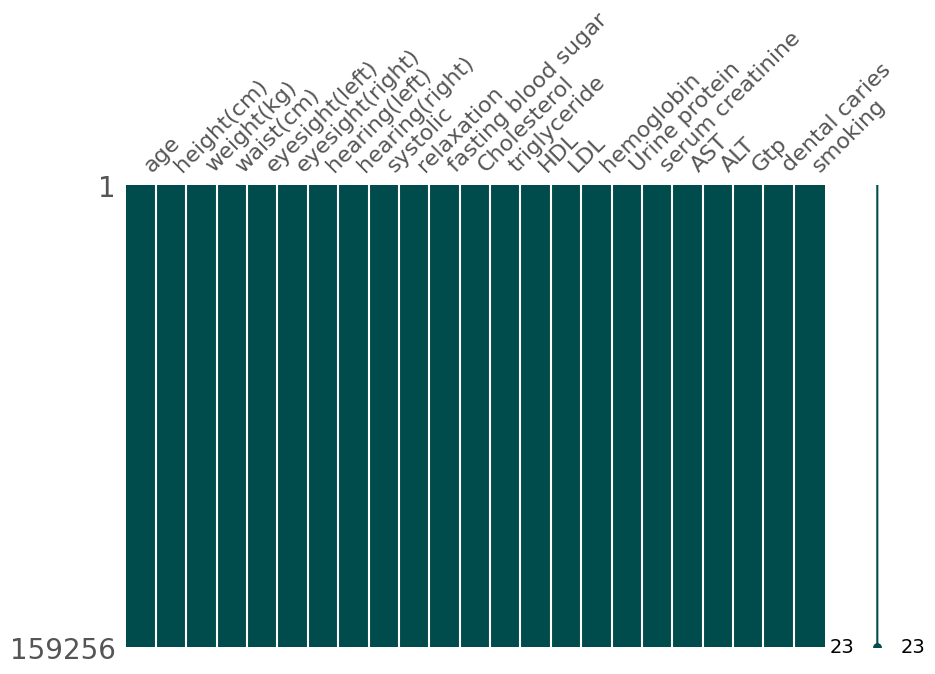

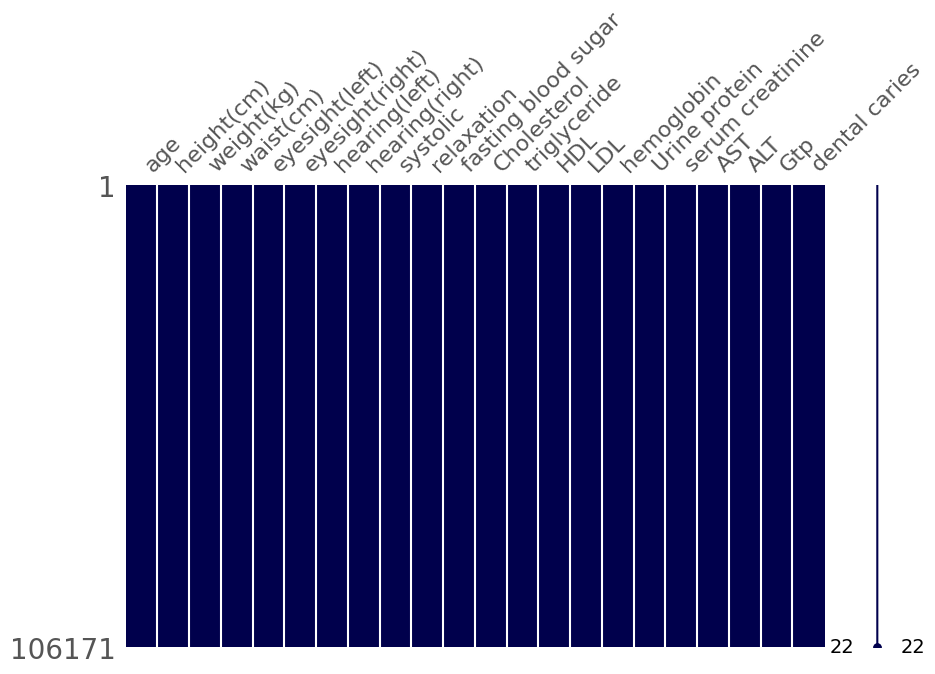

In [25]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

元々欠損値がないデータ

## 重複データ

In [26]:
total = pd.concat([train.drop(target_col, axis=1), test], axis=0) # 目的変数を指定する
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [27]:
train[train.columns].nunique().sort_values(ascending=True)

smoking                  2
dental caries            2
hearing(right)           2
hearing(left)            2
Urine protein            6
height(cm)              14
eyesight(right)         17
age                     18
eyesight(left)          20
weight(kg)              28
serum creatinine        28
relaxation              75
HDL                    108
systolic               112
hemoglobin             134
AST                    140
ALT                    188
LDL                    222
Cholesterol            227
fasting blood sugar    229
Gtp                    362
triglyceride           392
waist(cm)              531
dtype: int64

### 目的変数

In [28]:
print(target_name +' Class labels:', np.unique(target))

['smoking'] Class labels: [0 1]


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

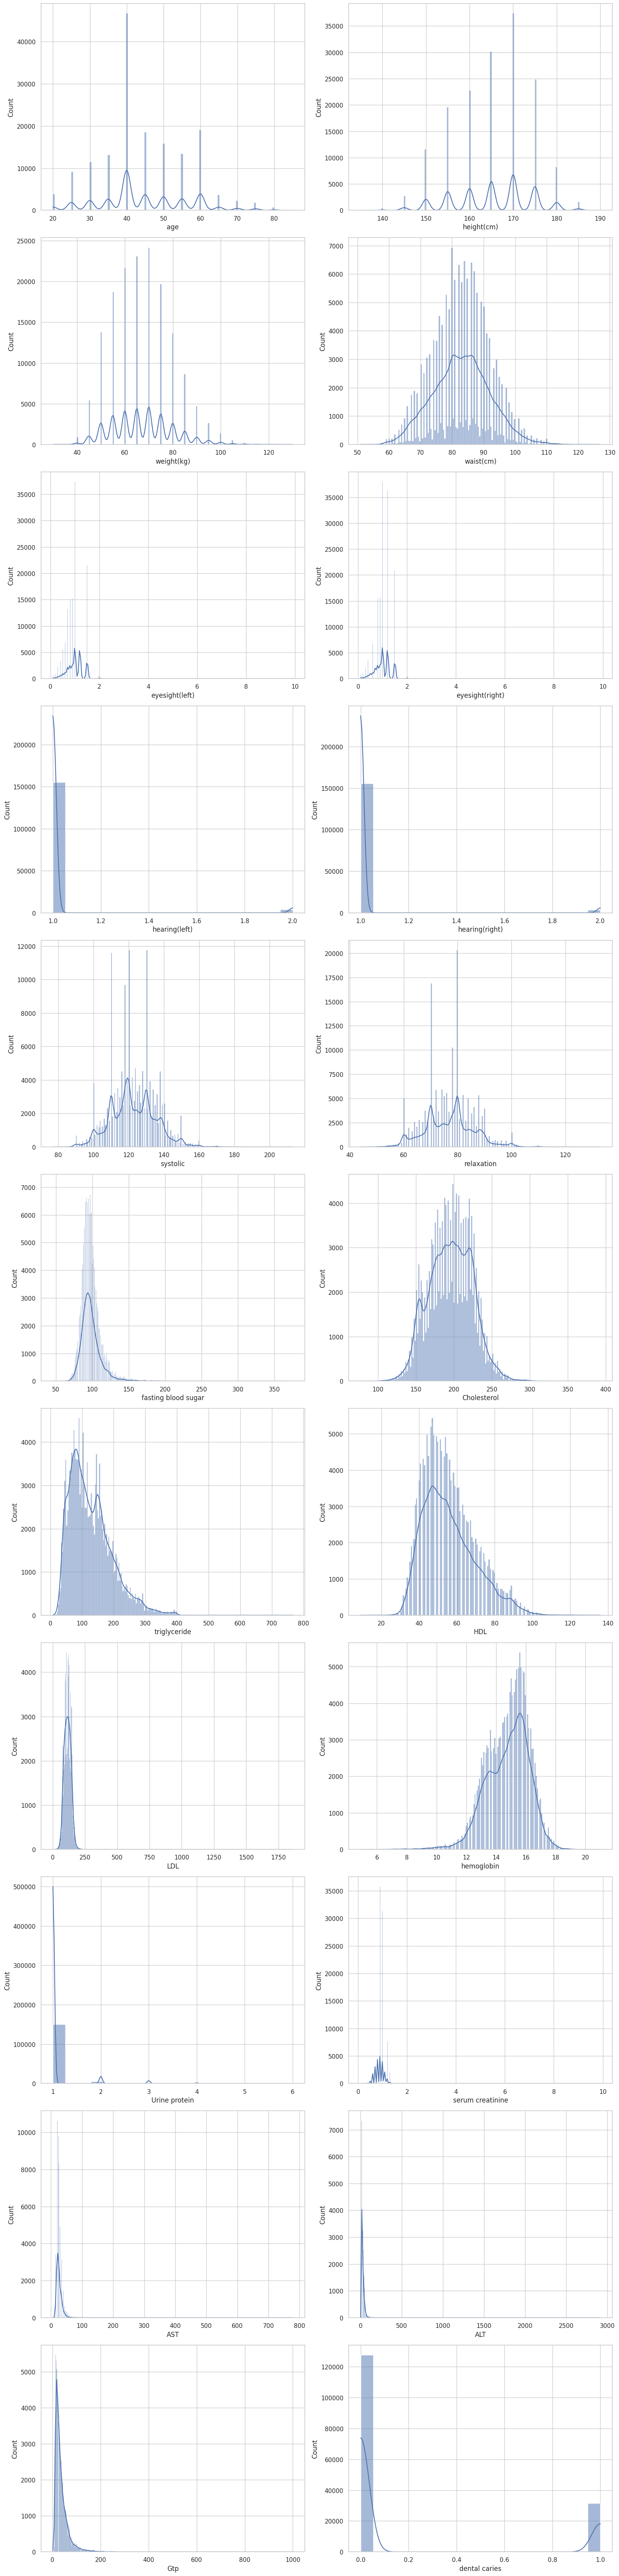

In [29]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

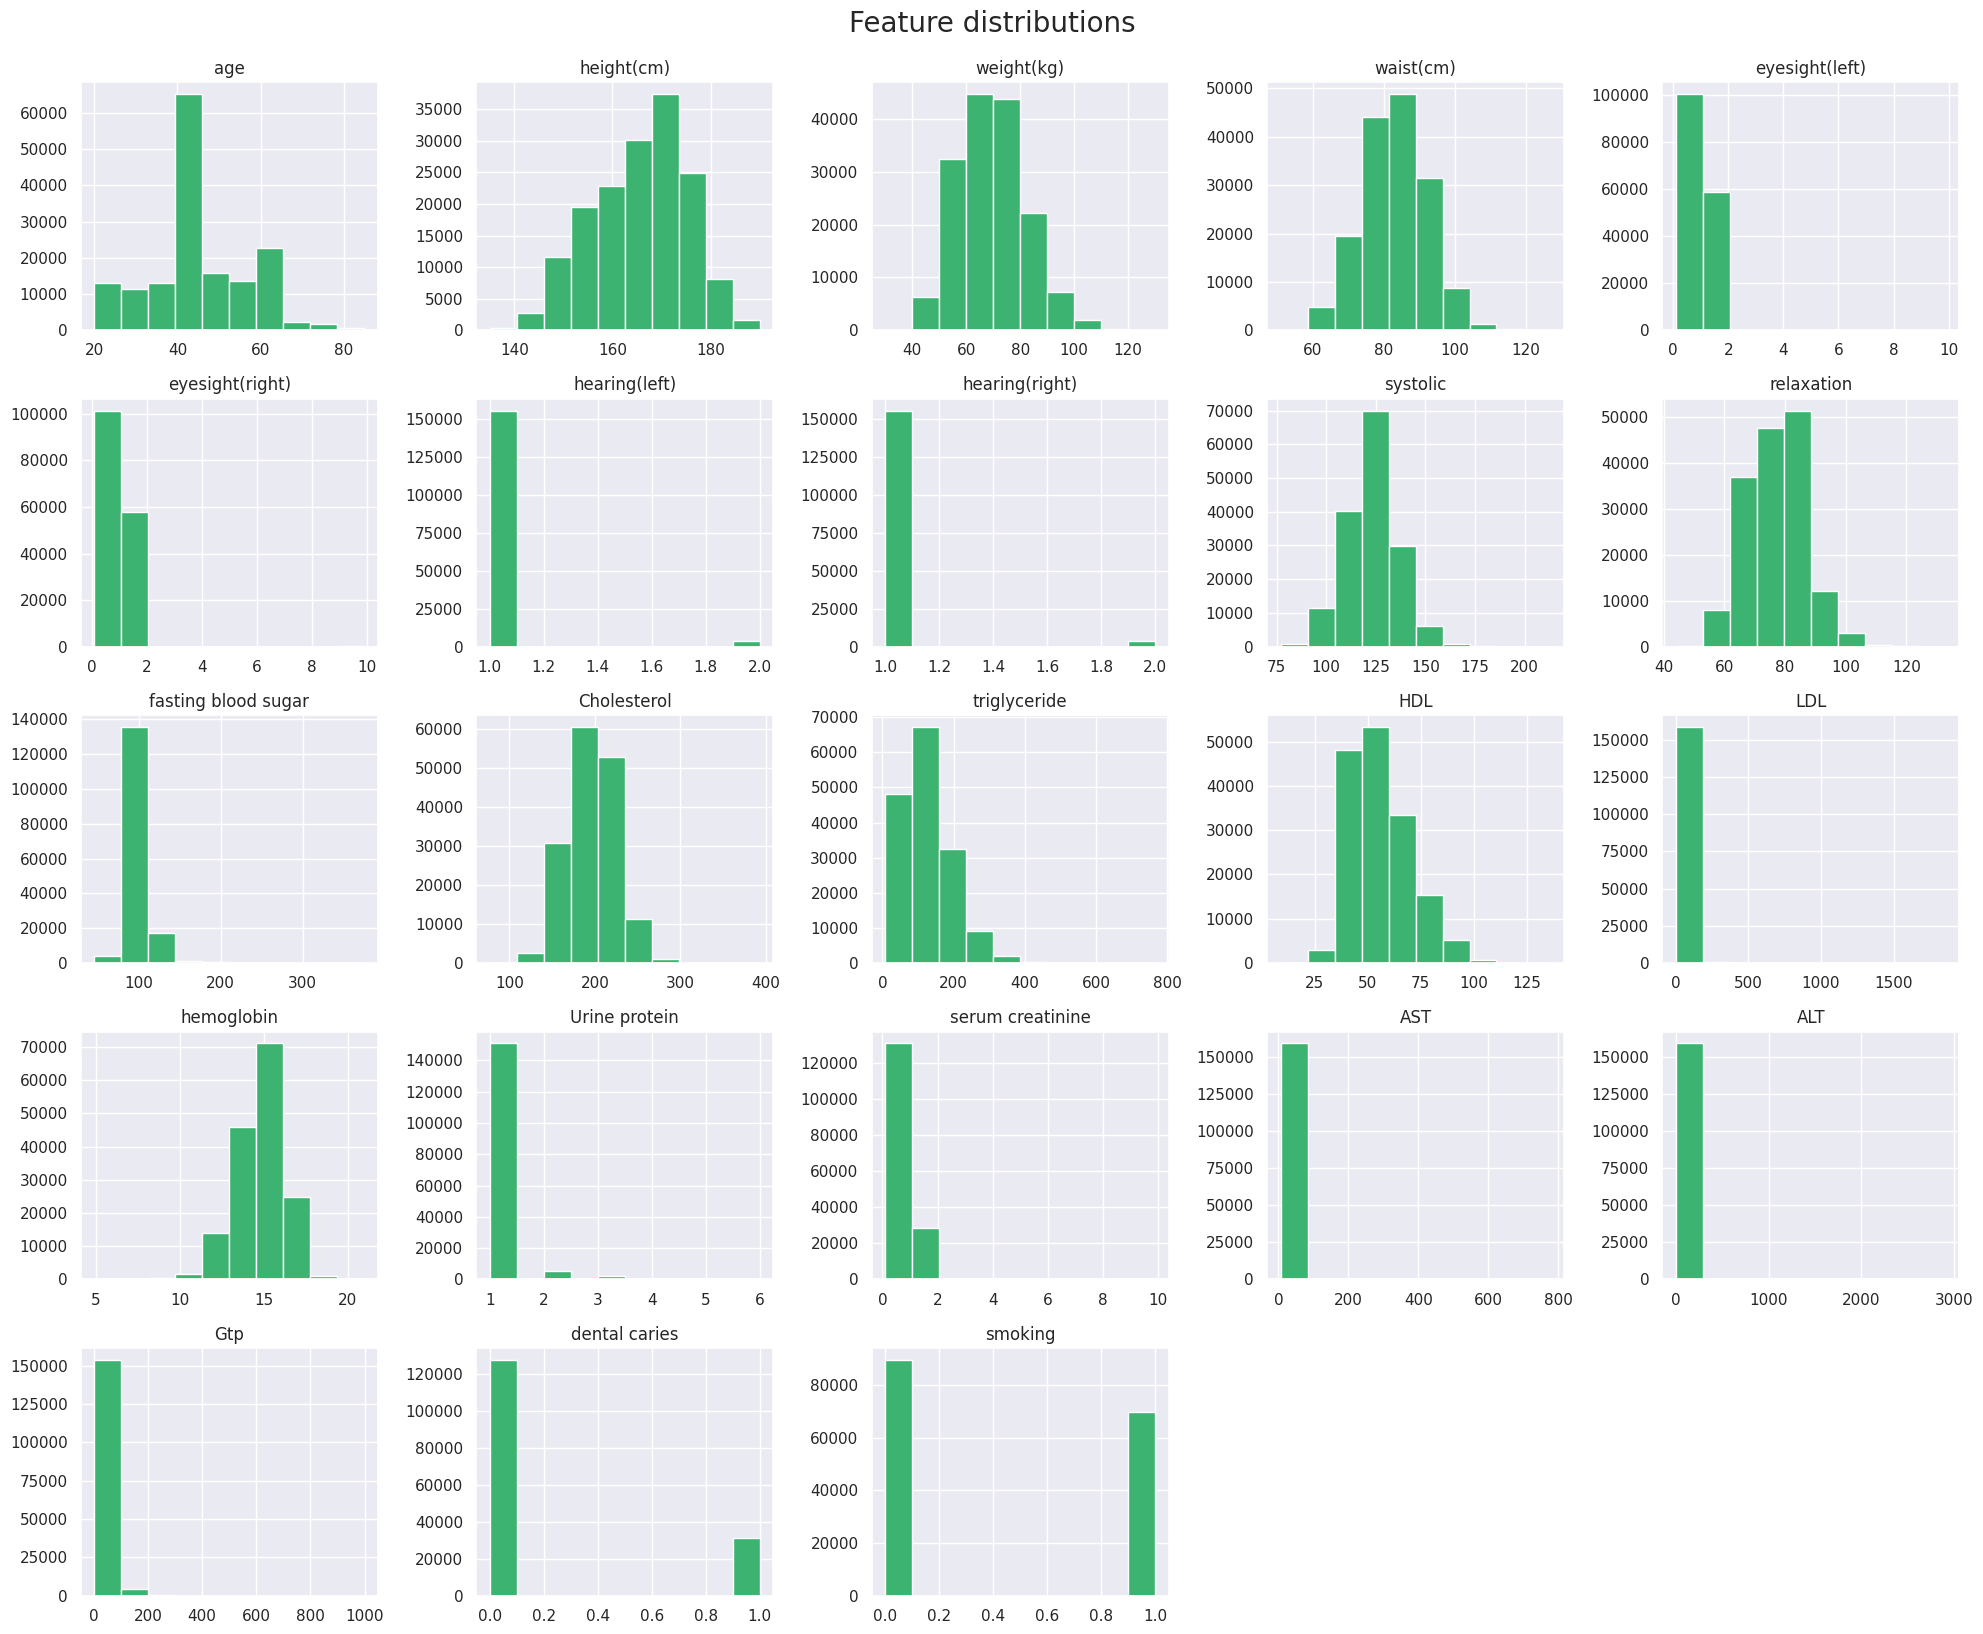

In [30]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

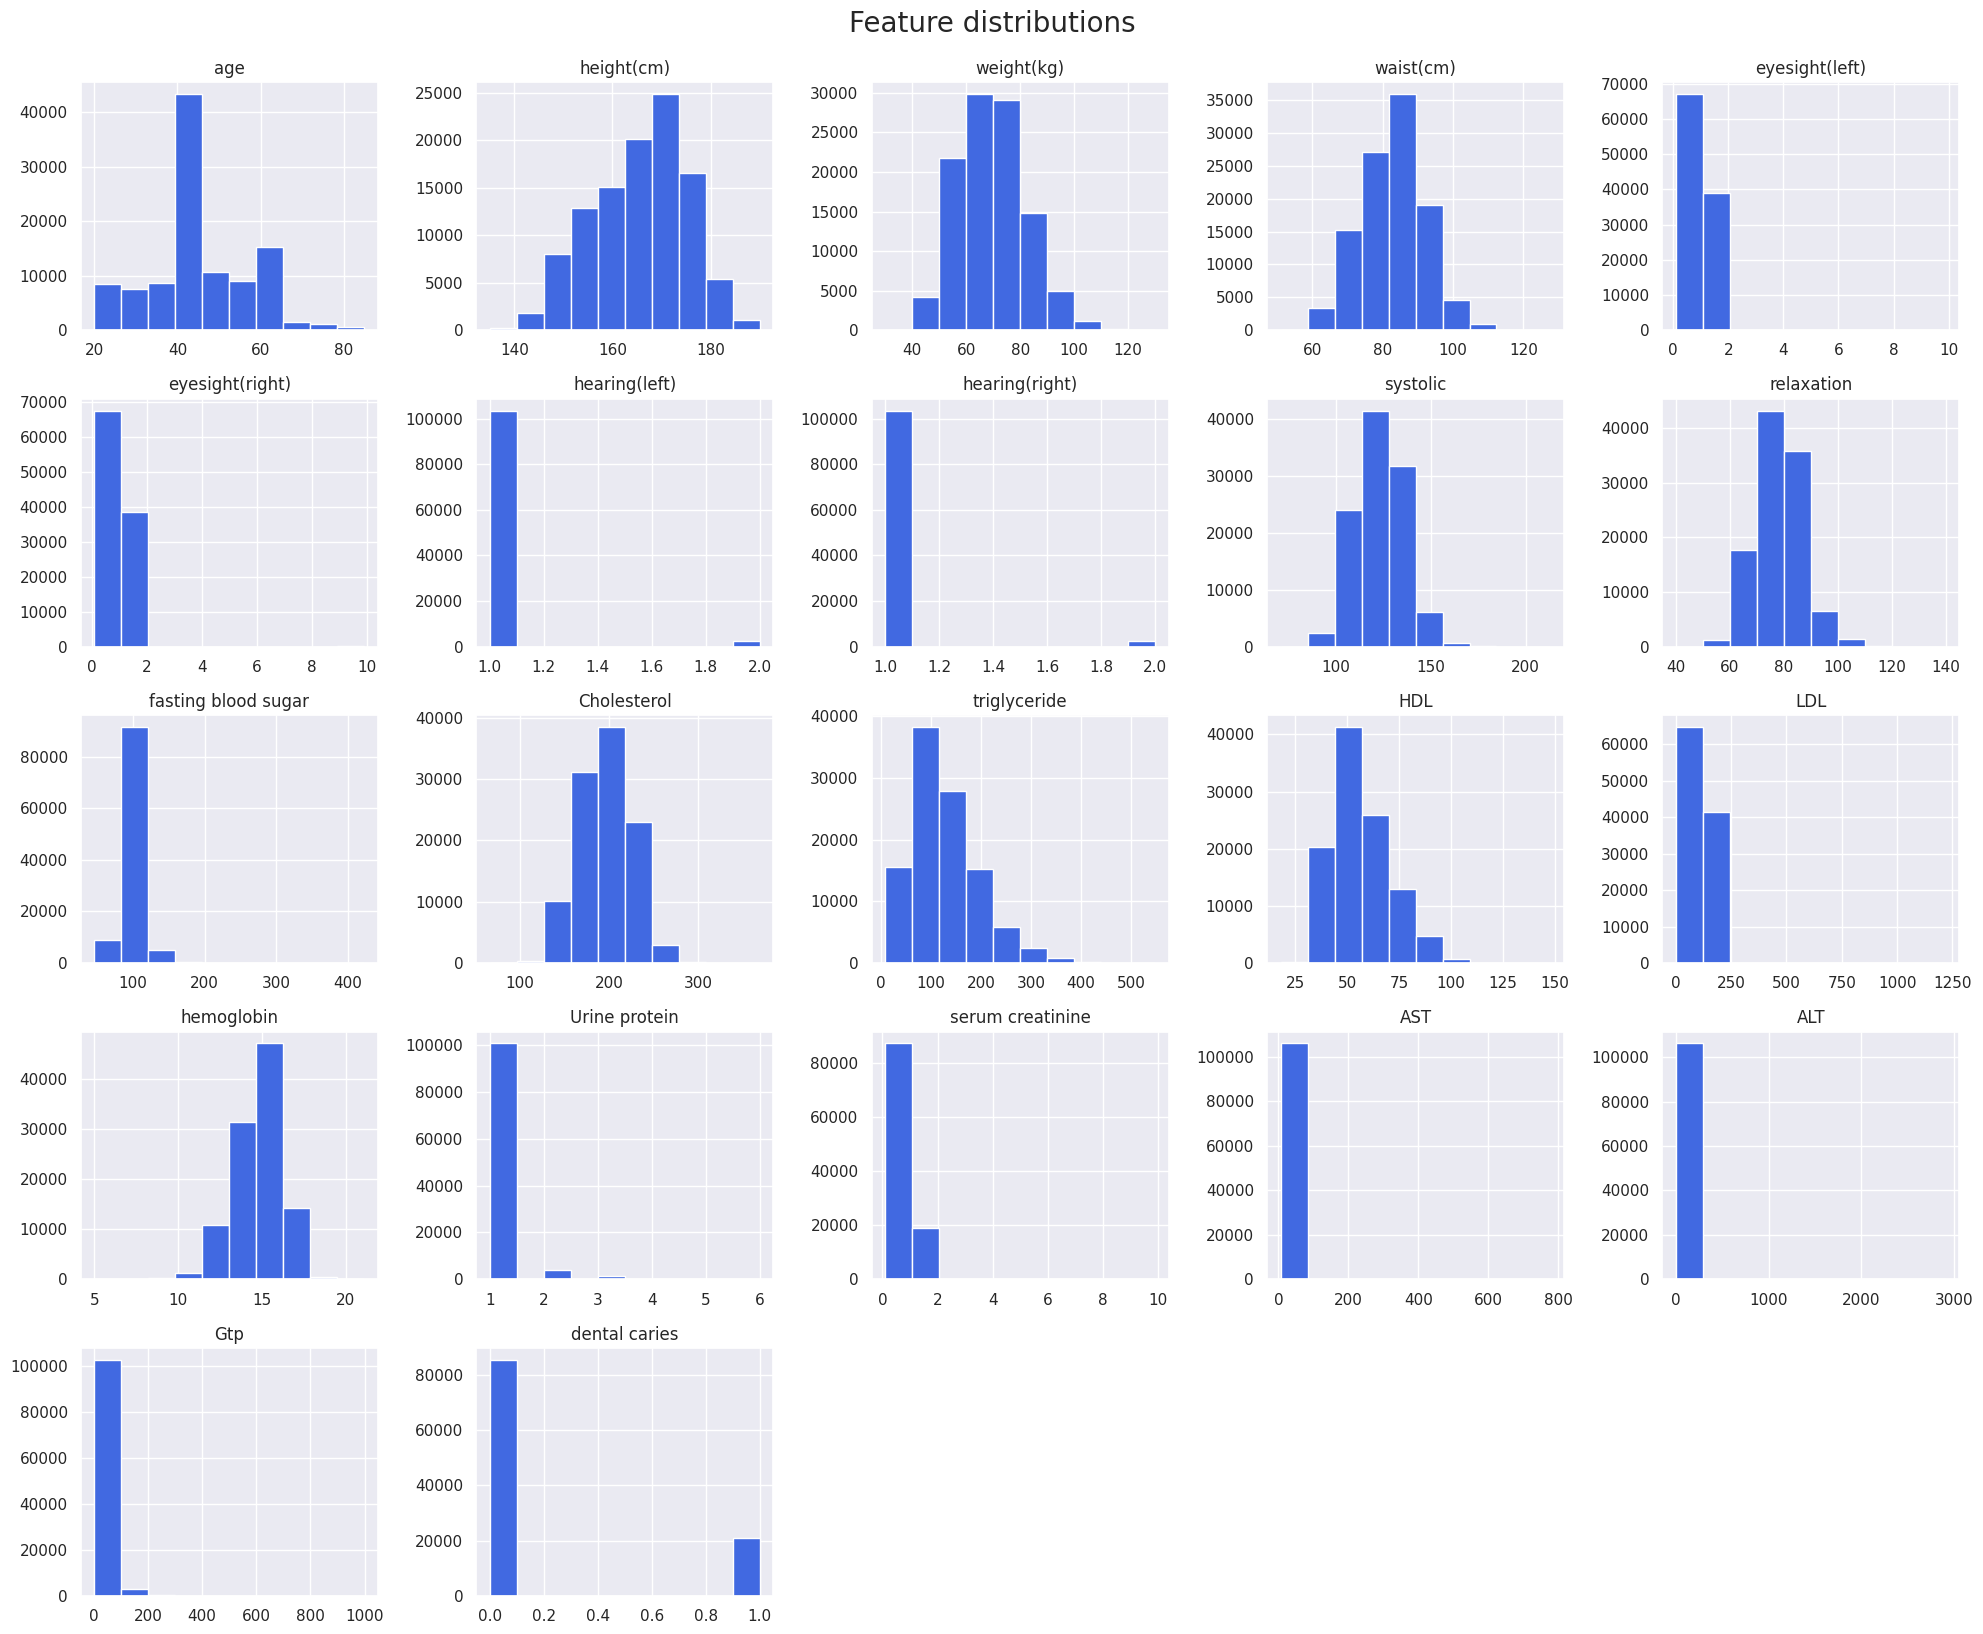

In [31]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

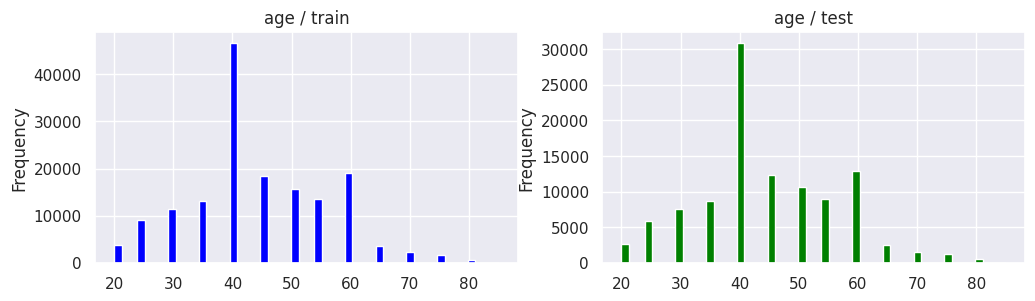

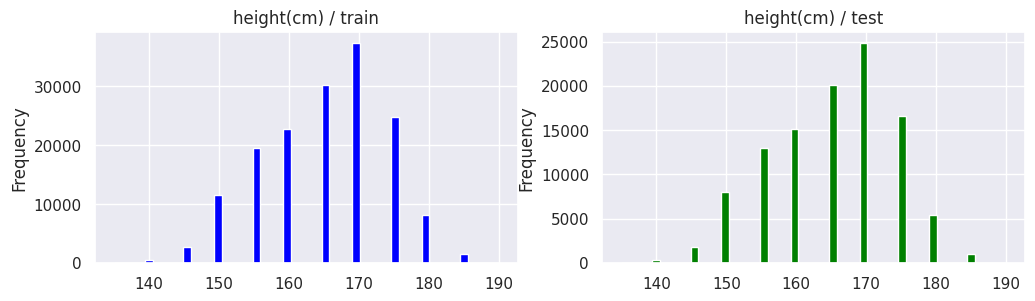

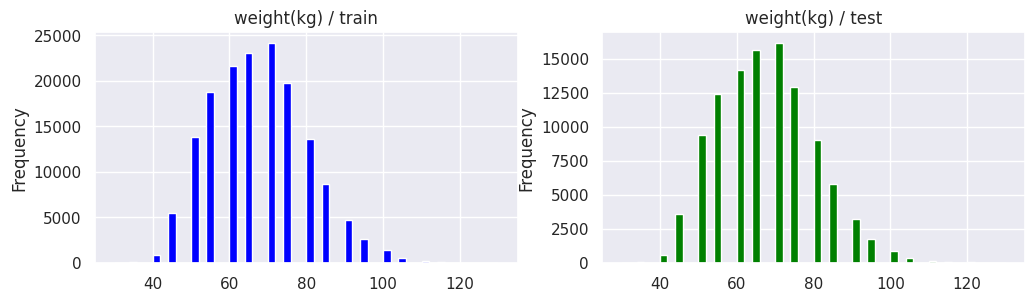

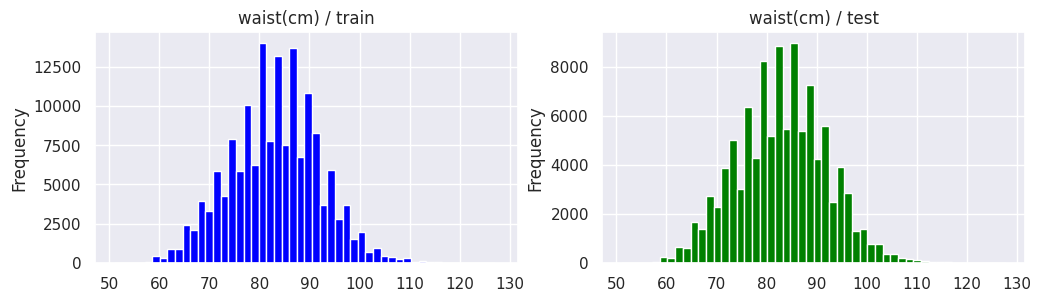

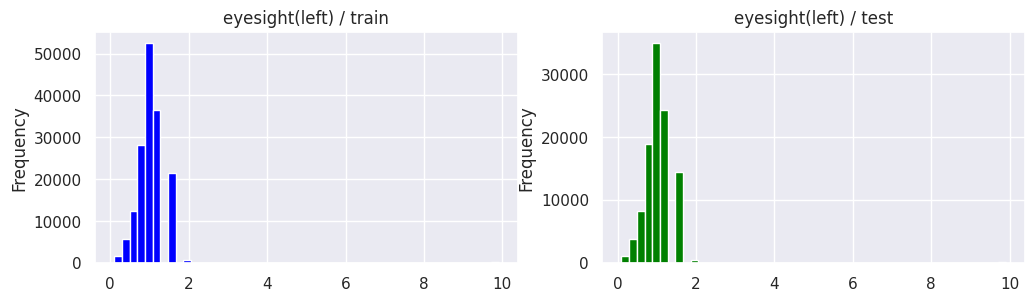

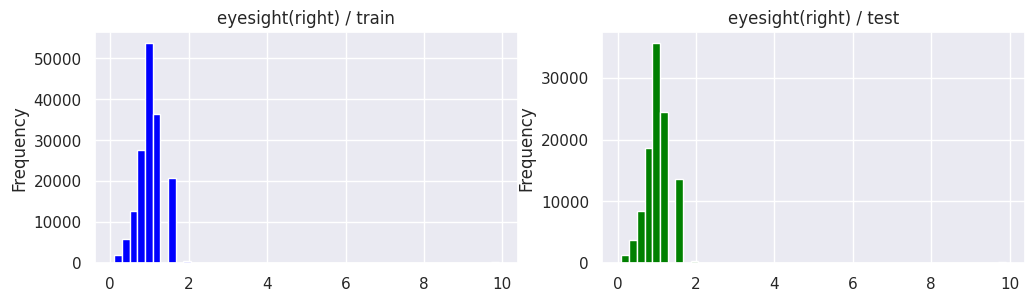

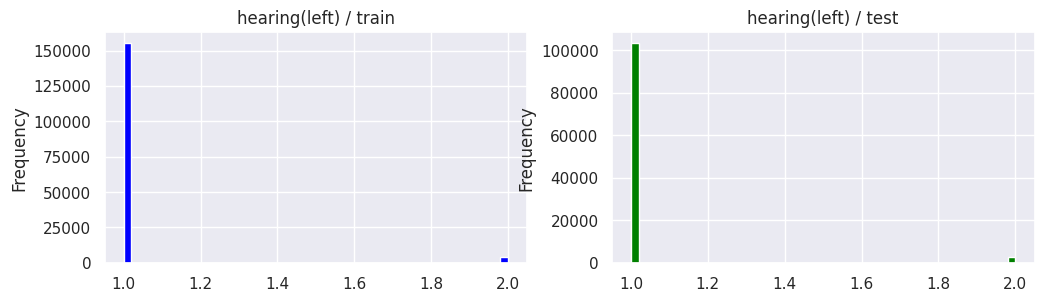

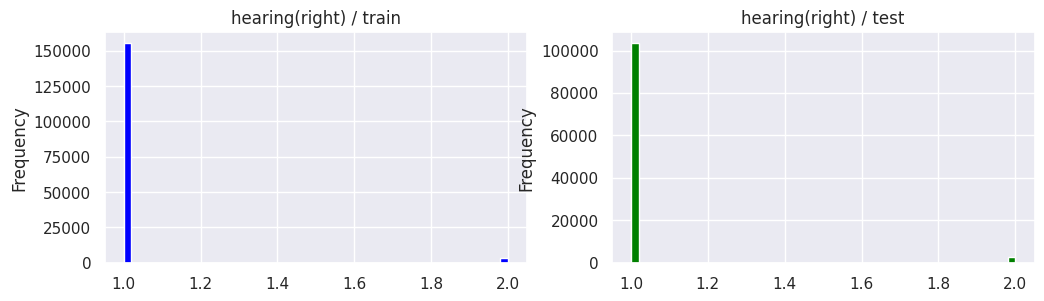

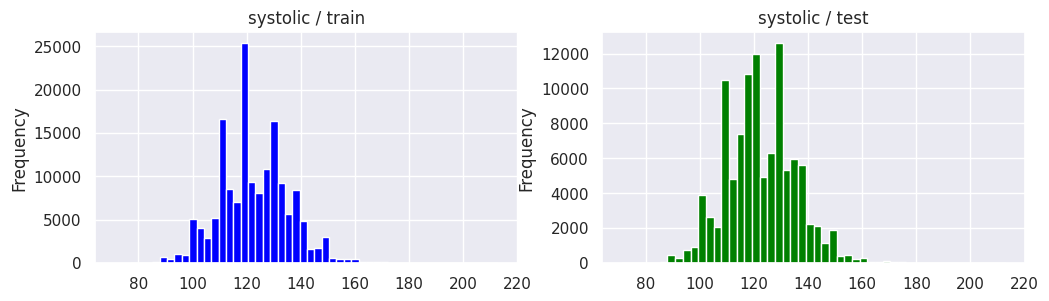

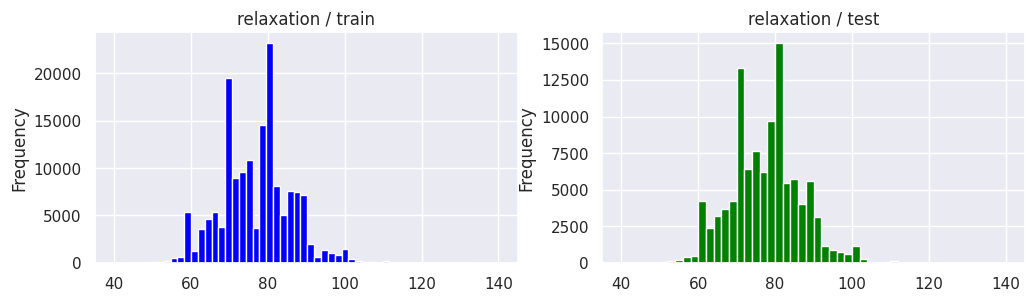

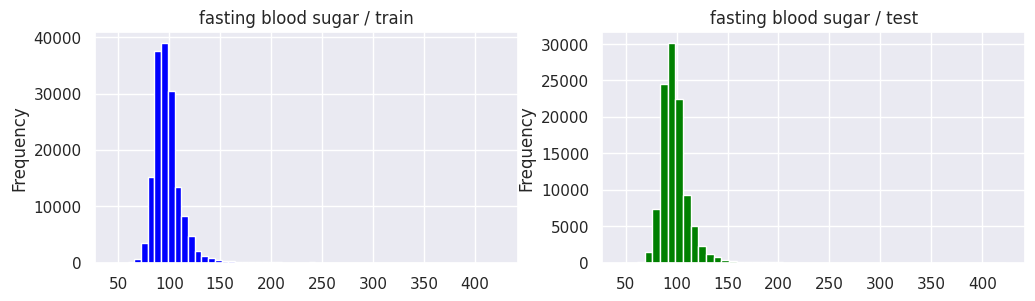

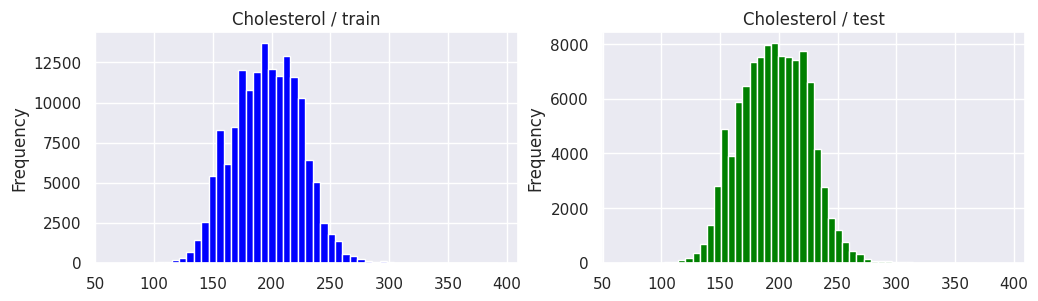

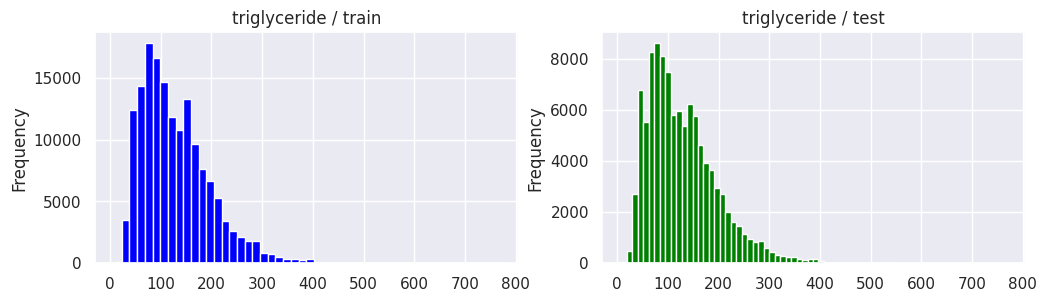

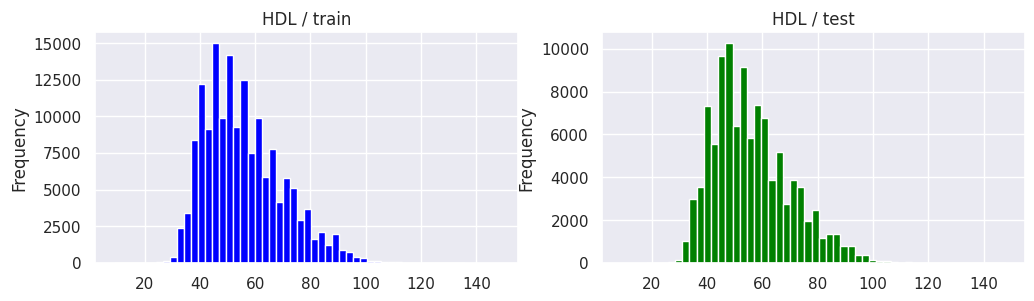

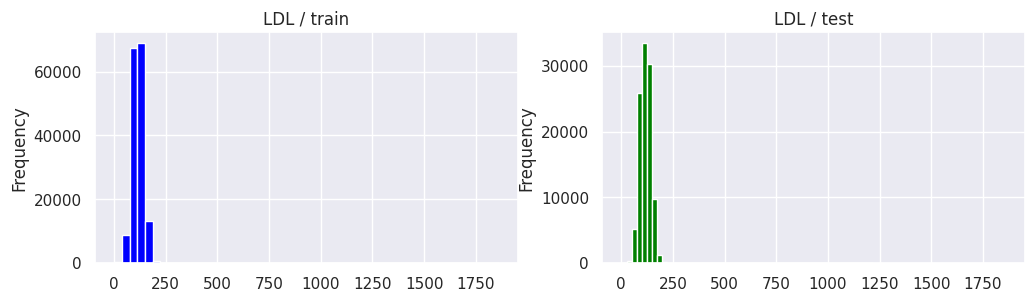

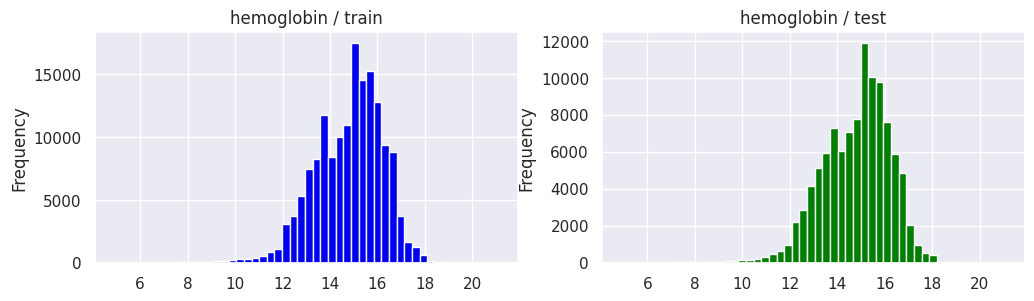

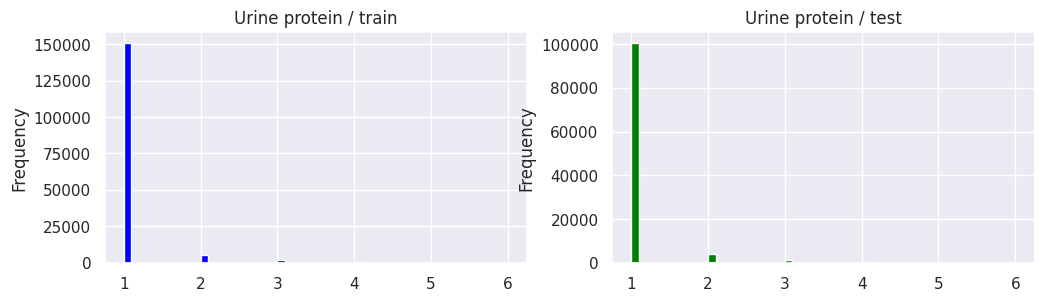

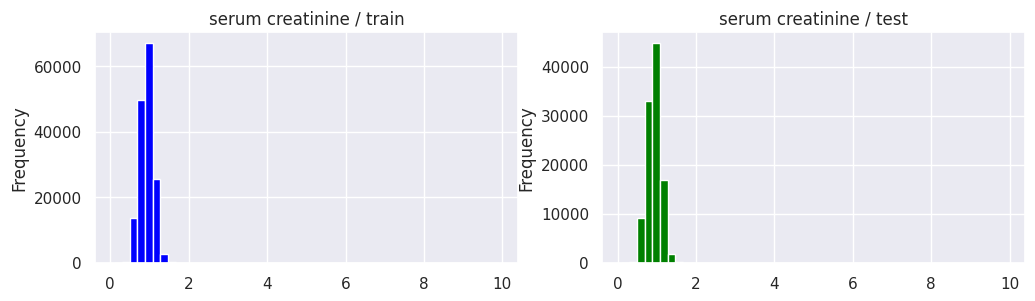

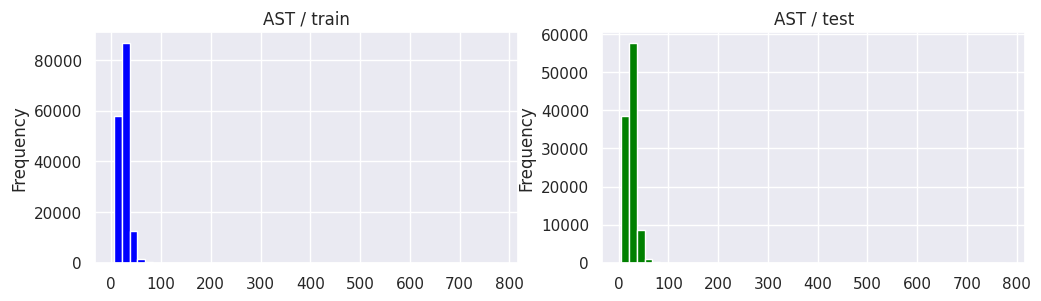

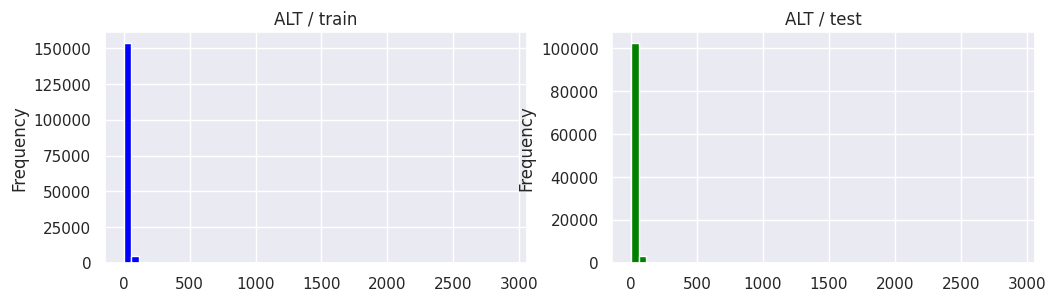

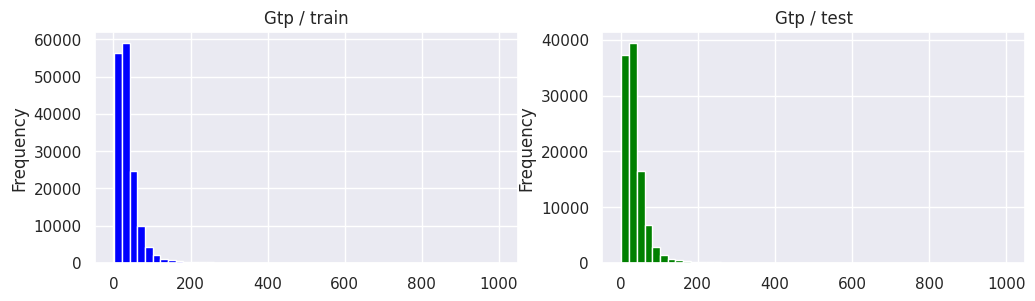

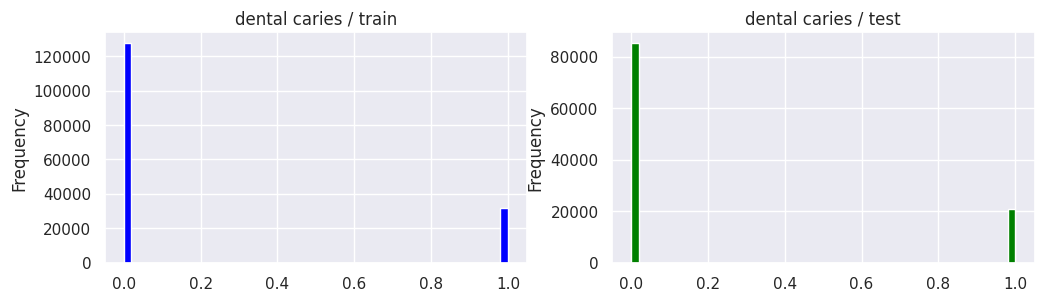

In [32]:
feature = train[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

#### データを対数変換する

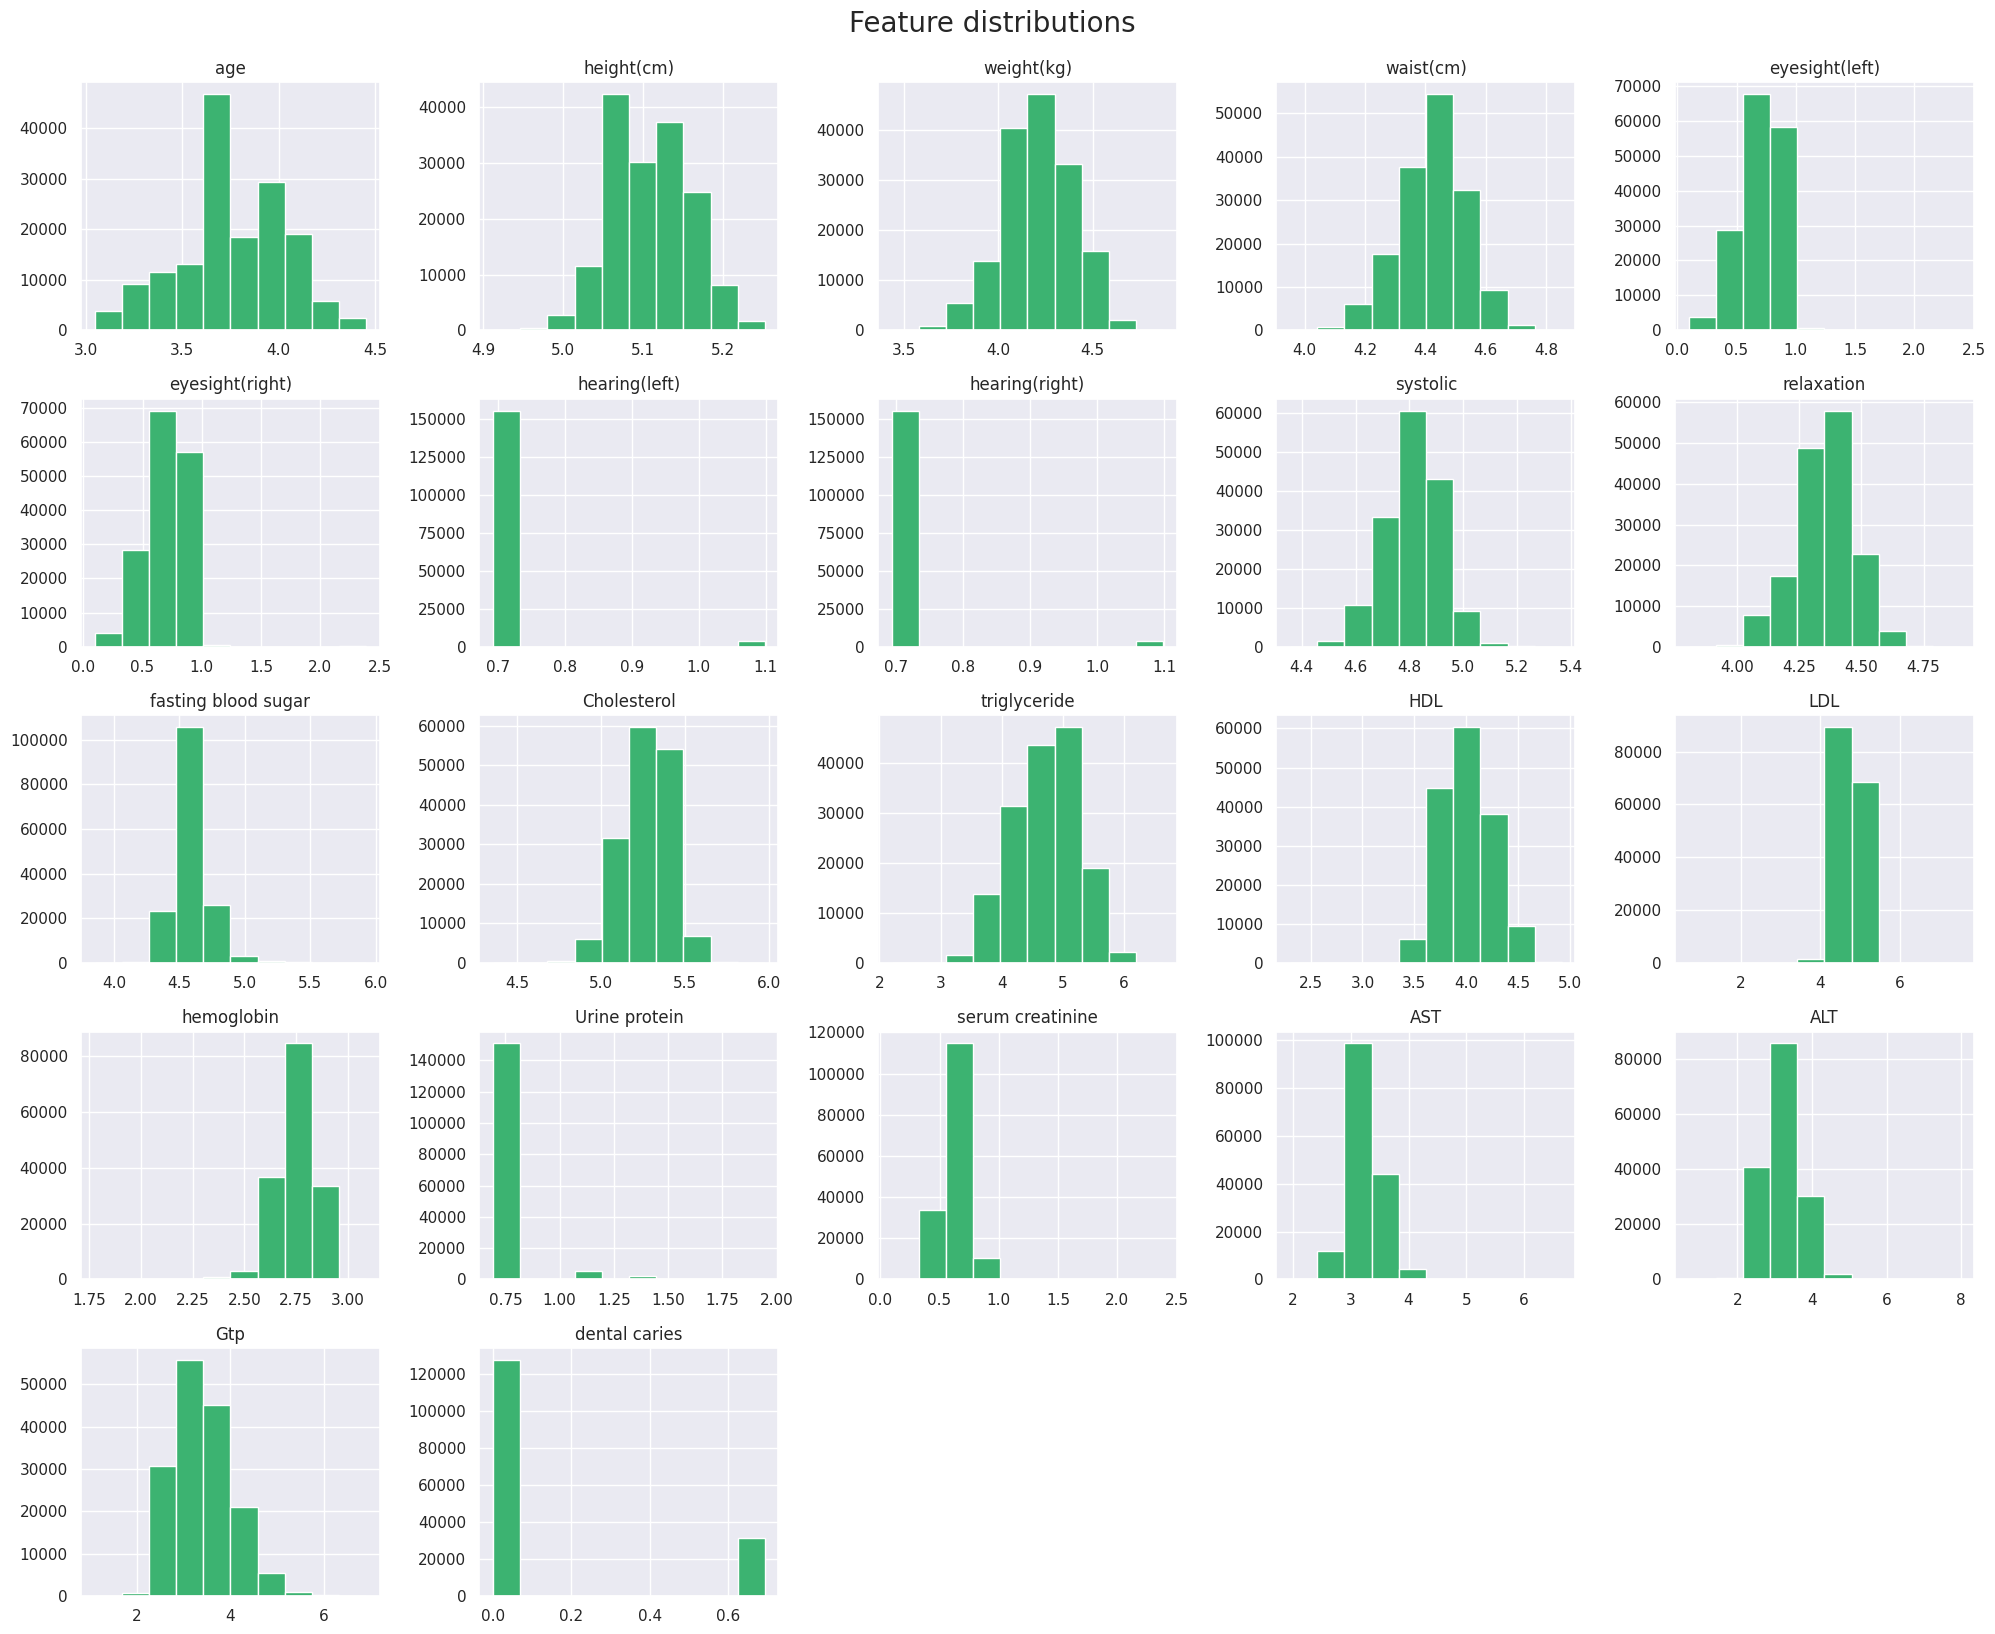

In [33]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train[numerical_features]
y = target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

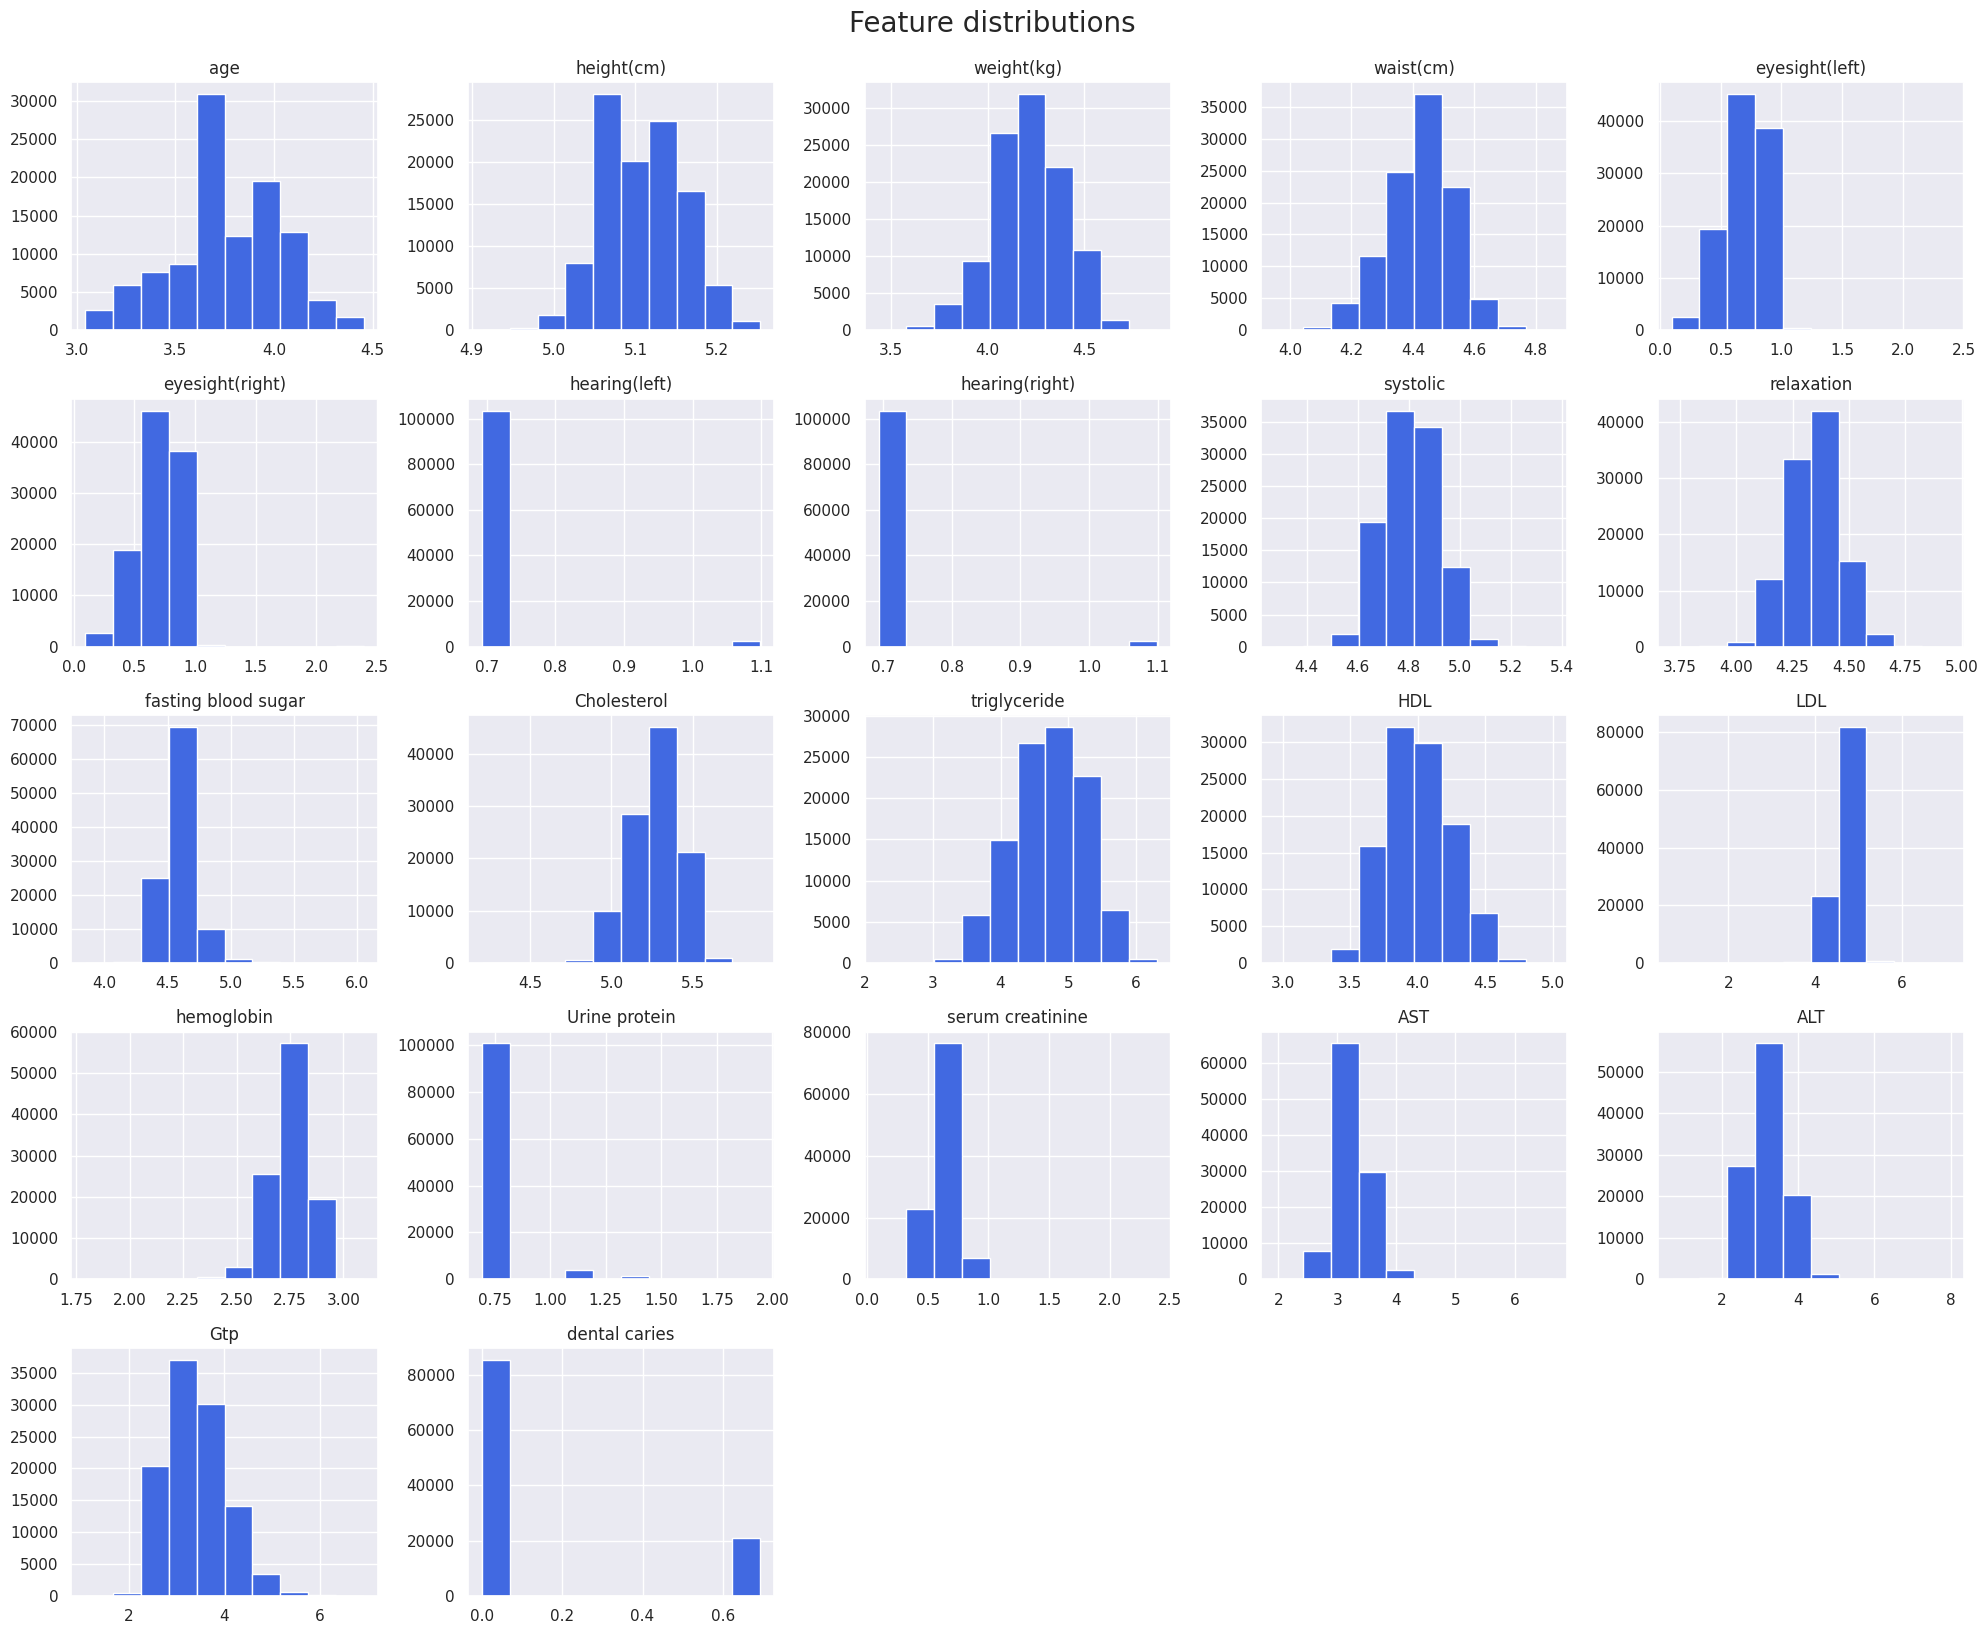

In [34]:
# テストデータも変換する
test_log = test[numerical_features]
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

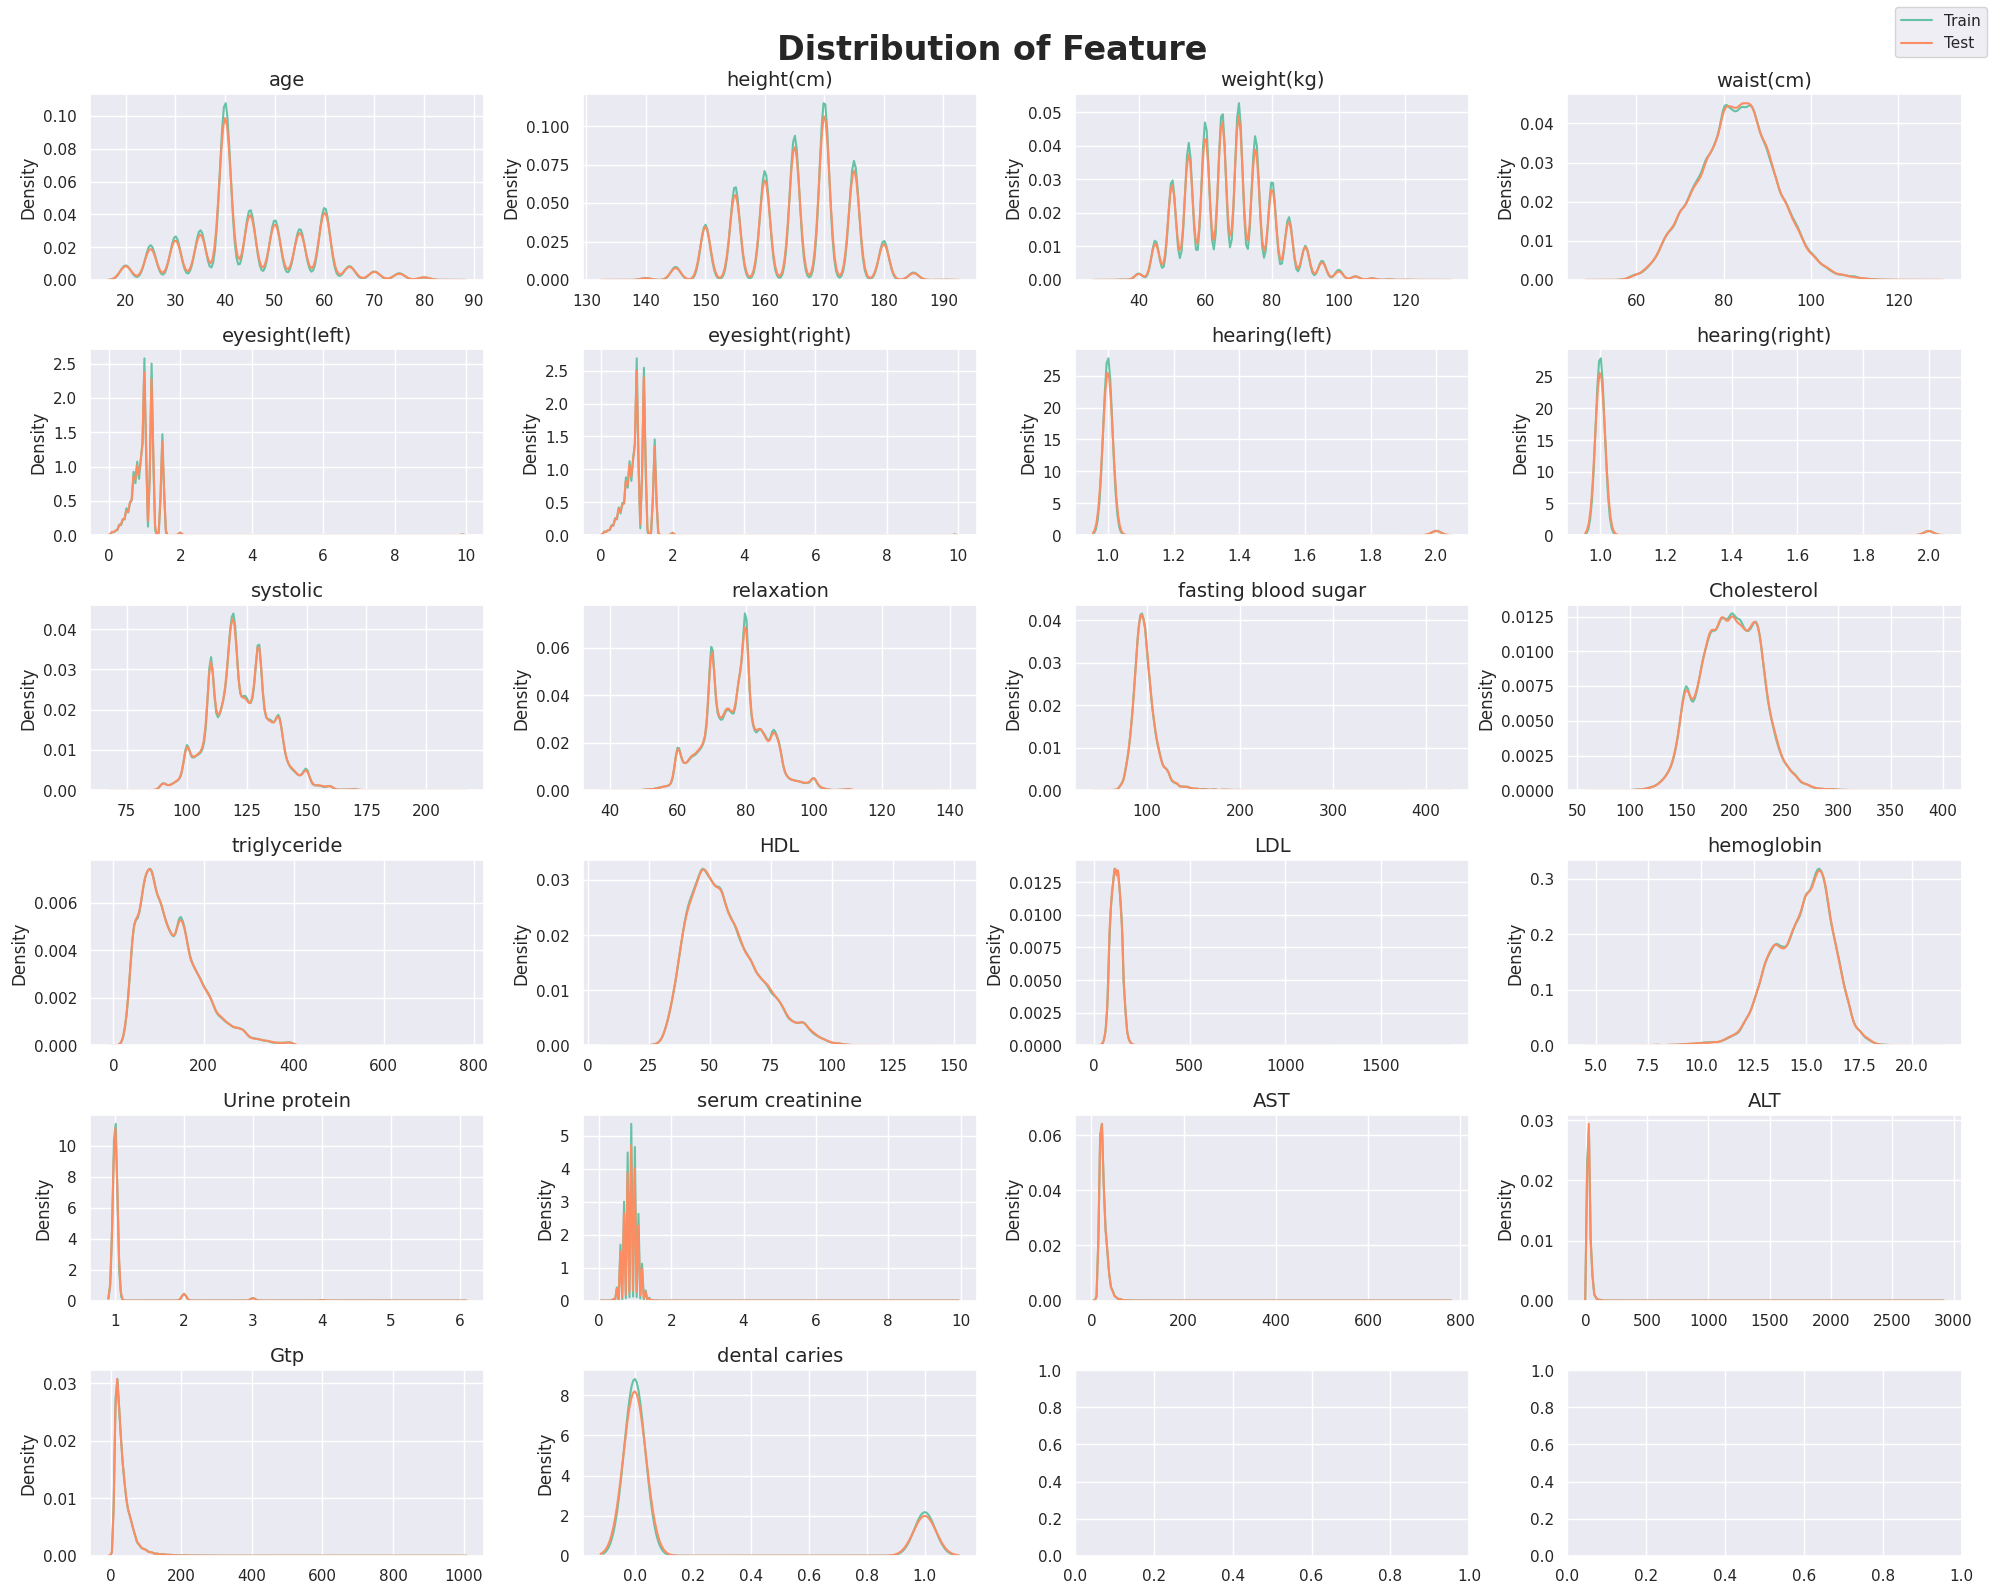

In [35]:
fig, ax = plt.subplots(len(numerical_features) // 4 + 1, 4)
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

In [36]:
# 時間がかかるため、割愛
# def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
#     adv_train = dataset_1.drop(target_col, axis=1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index=True)
#     adv_shuffled = adv.sample(frac=1)
#     adv_X = adv_shuffled.drop('is_test', axis=1)
#     adv_y = adv_shuffled.is_test

#     skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
#         adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)

#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

#     plt.figure(figsize=(10, 10), dpi=300)
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()

## 円グラフと棒グラフ

### 円グラフと棒グラフ（目的変数）

smoking
0    89603
1    69653
Name: count, dtype: int64


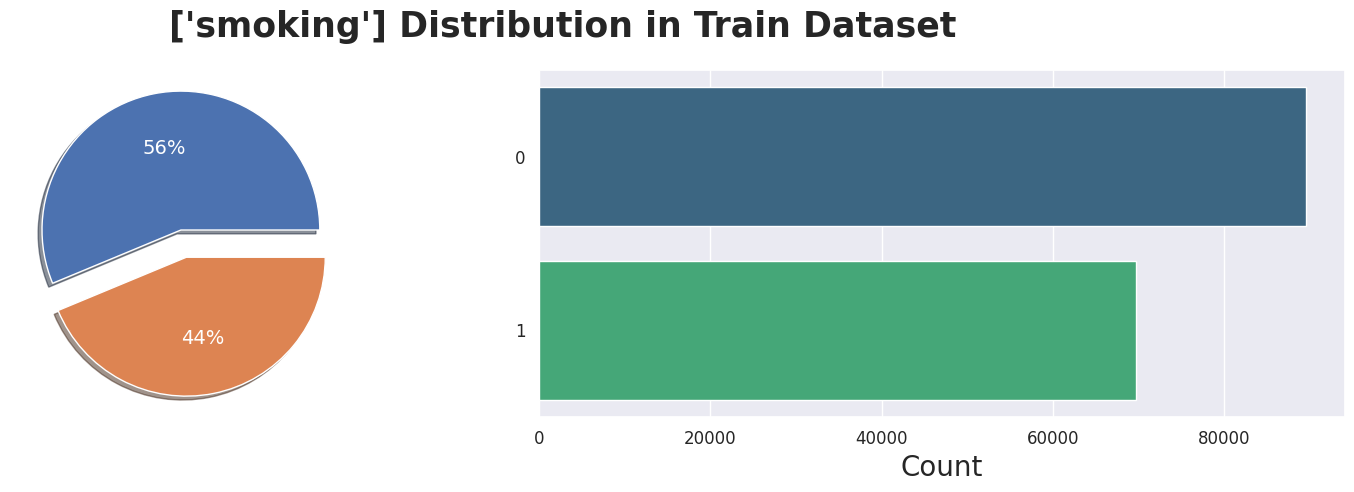

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target_col, ax=ax[1], palette='viridis', order=train[target_col].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train[target_col].value_counts()}') # 目的変数を指定する

### 箱ひげ図

数値型の説明変数

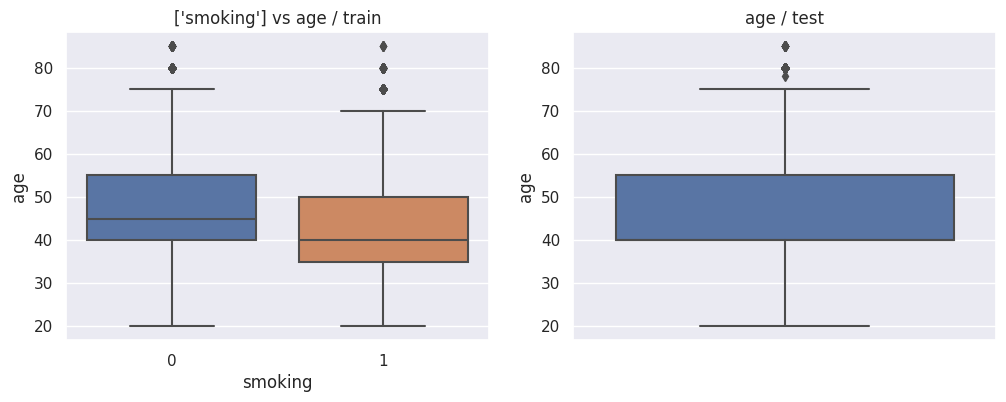

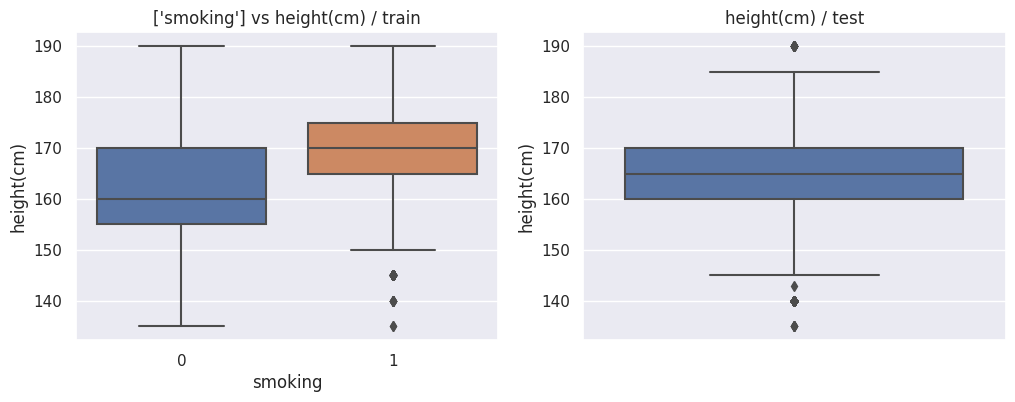

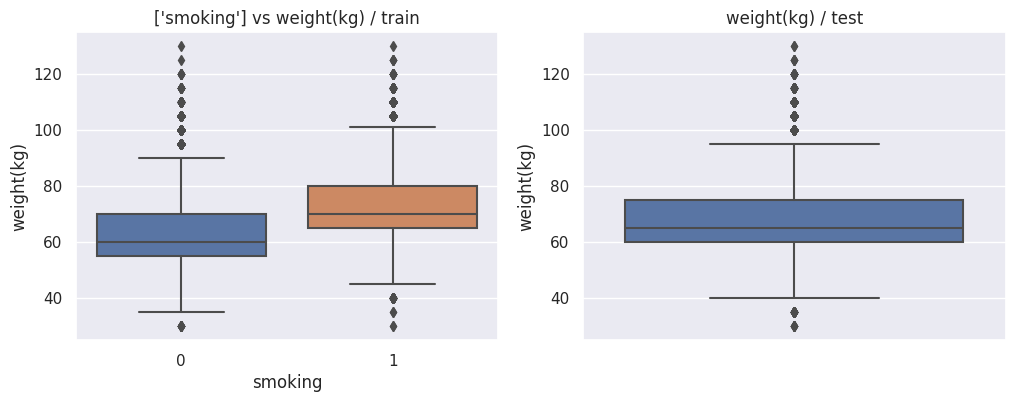

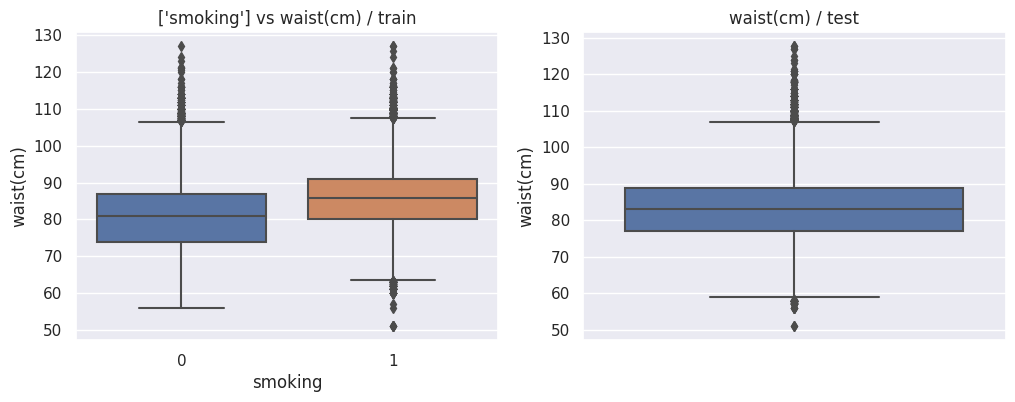

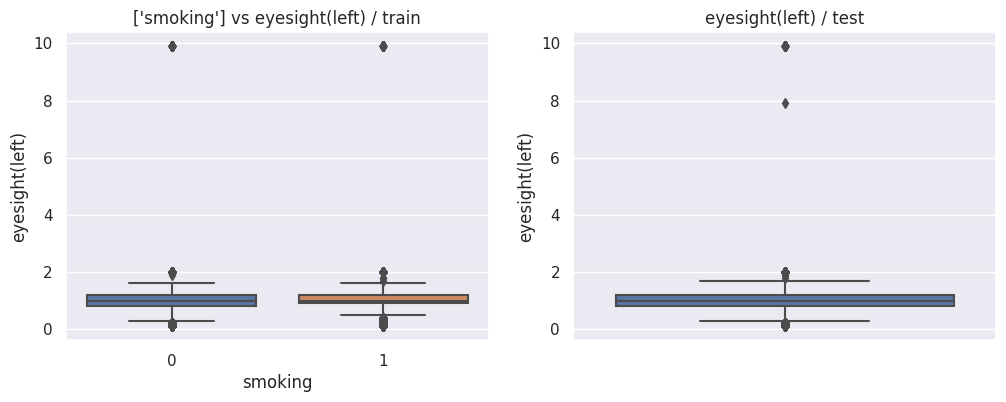

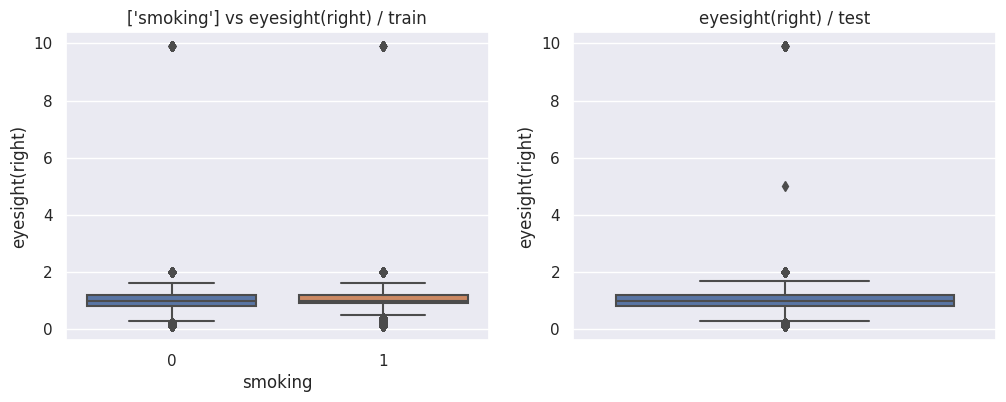

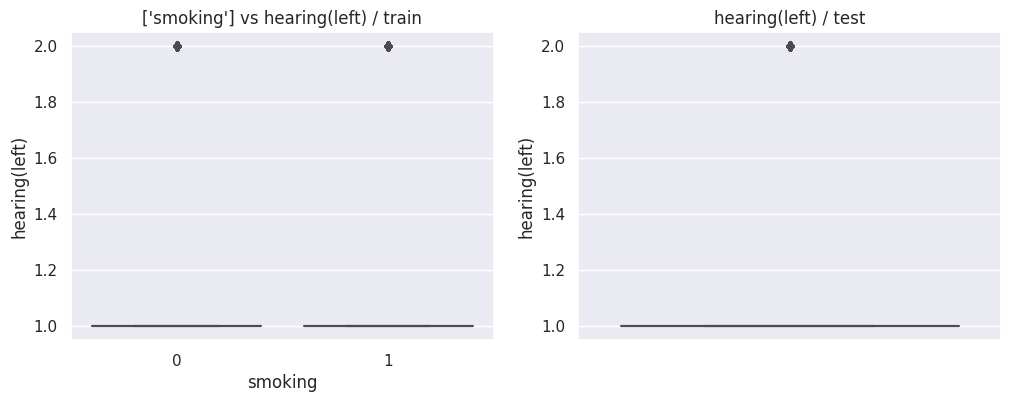

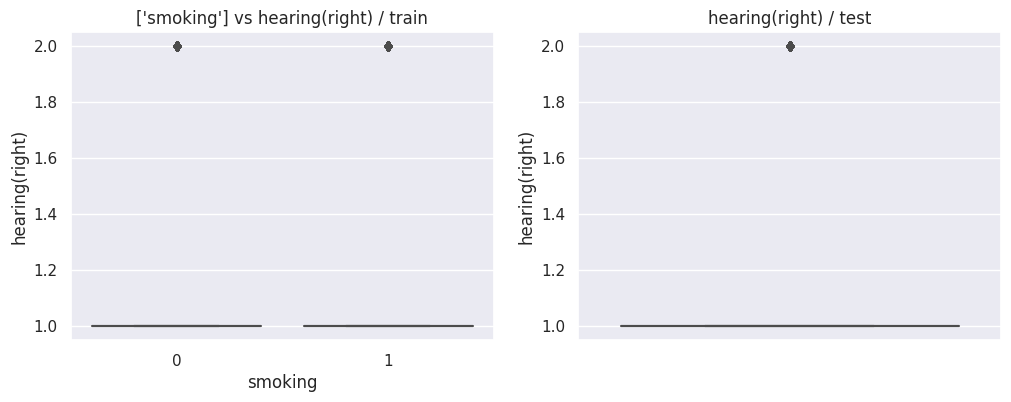

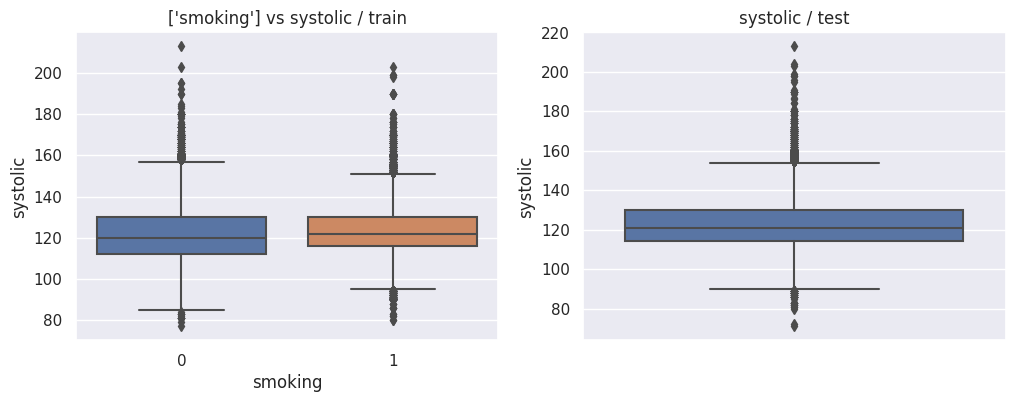

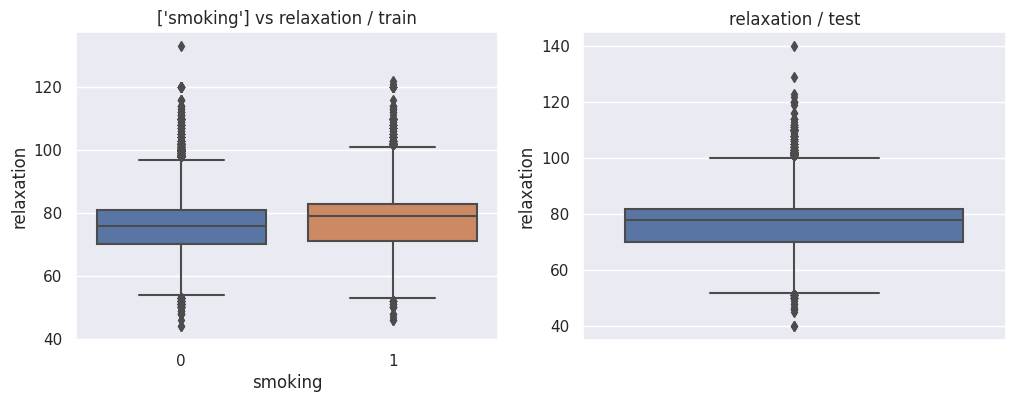

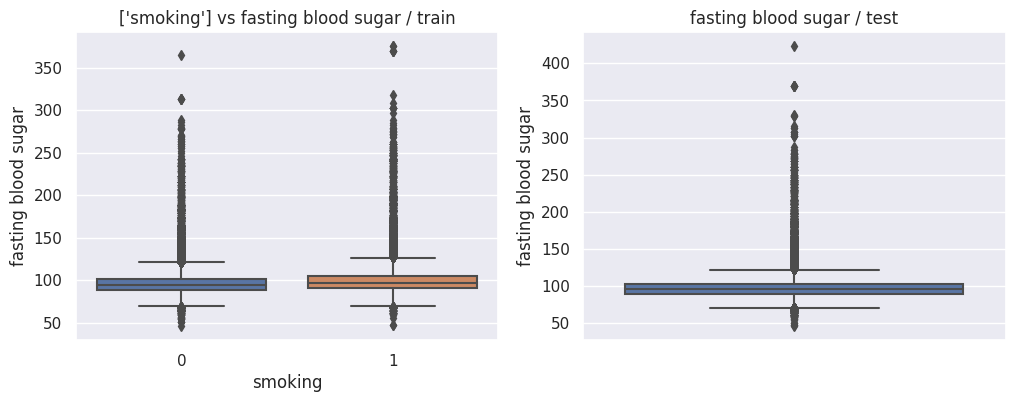

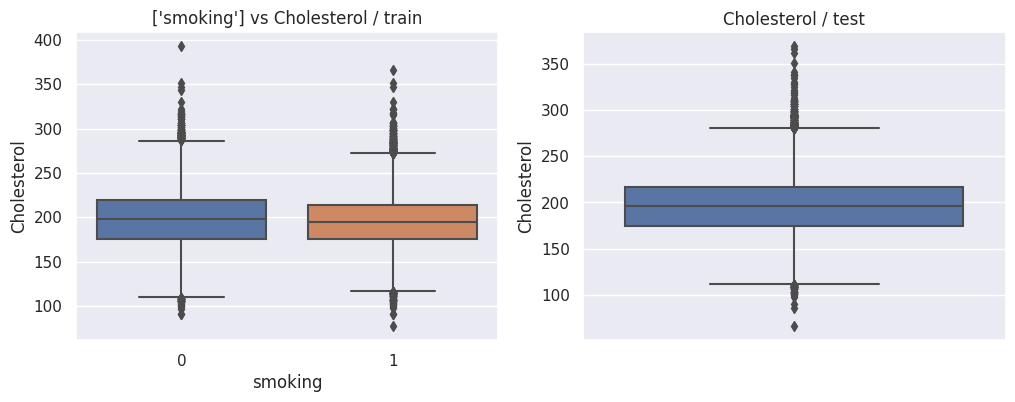

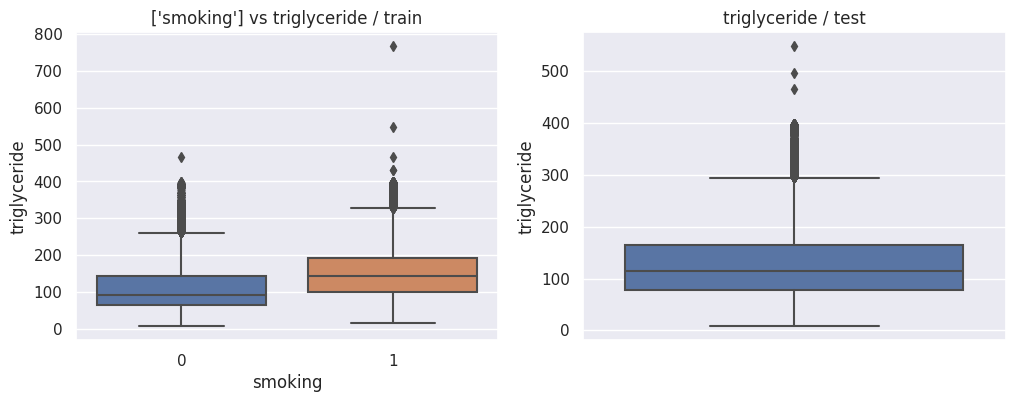

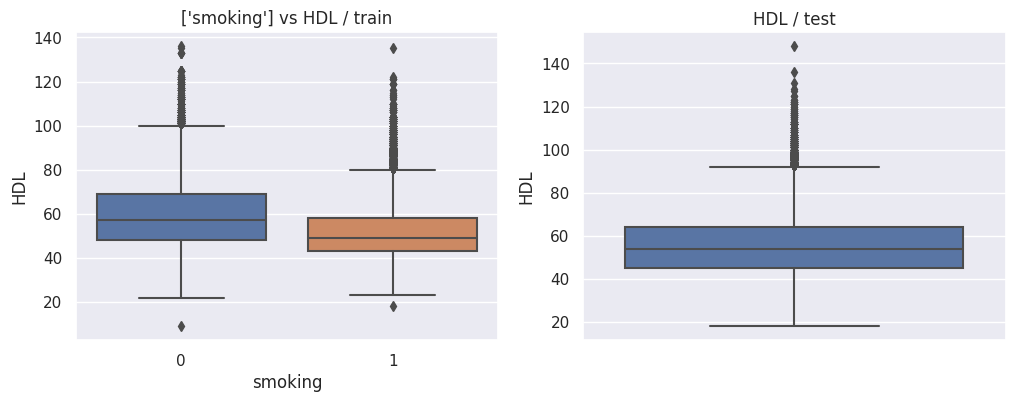

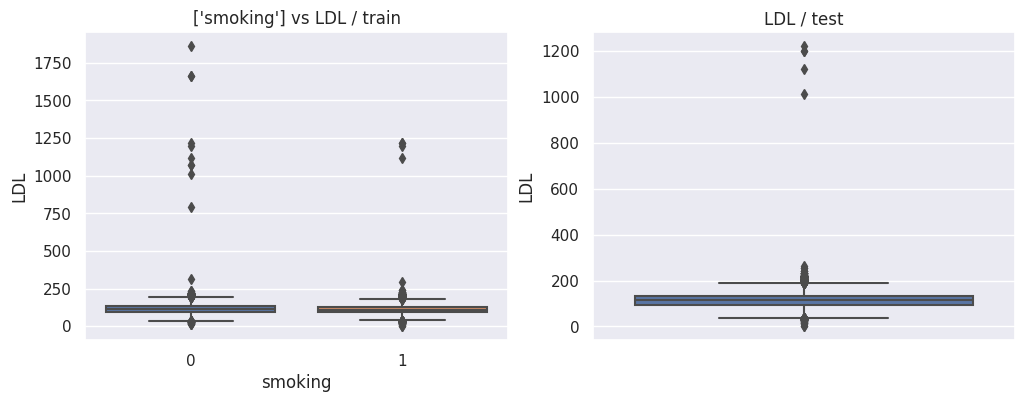

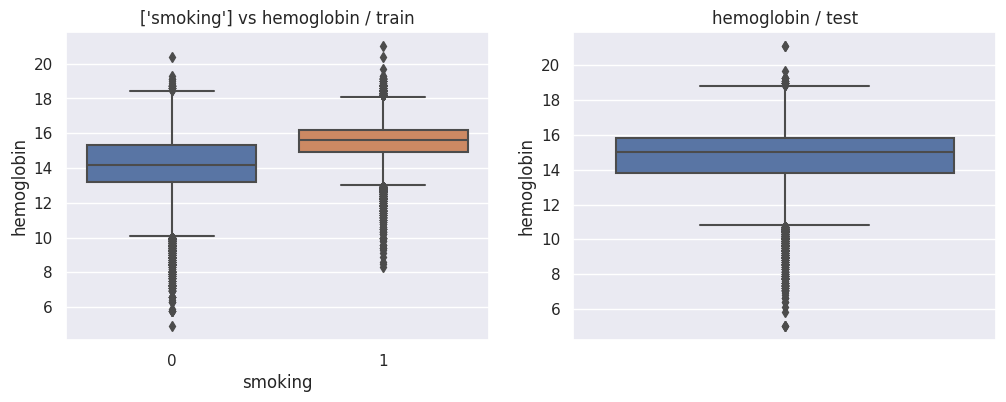

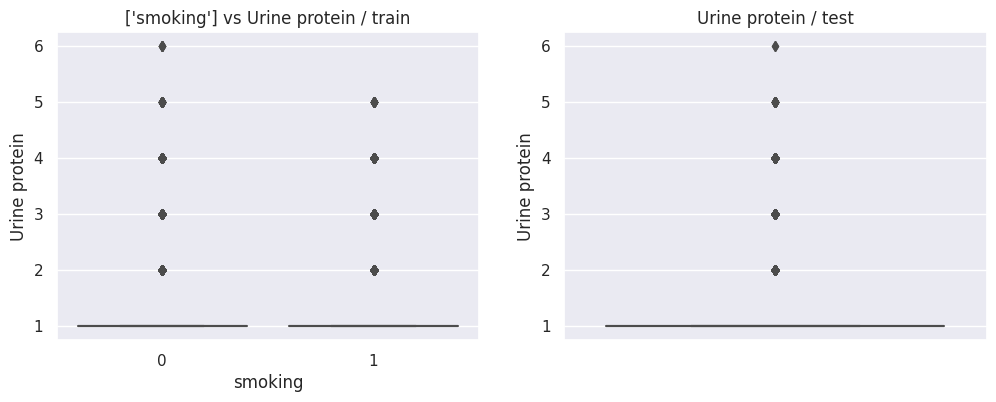

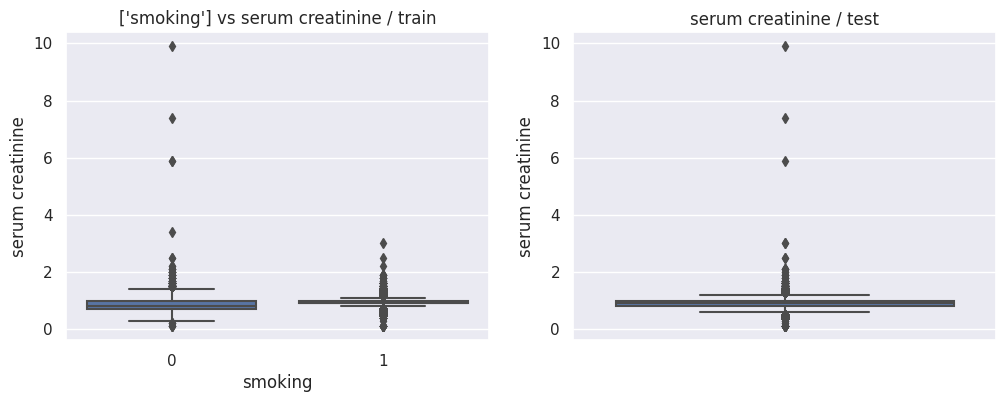

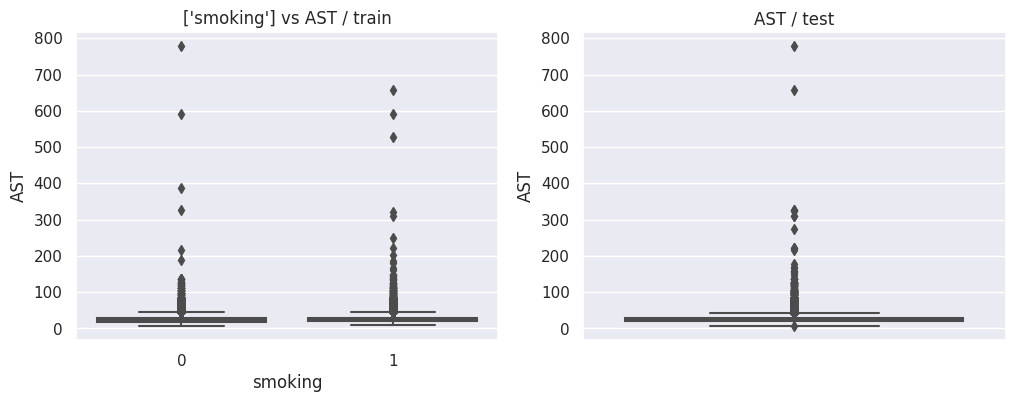

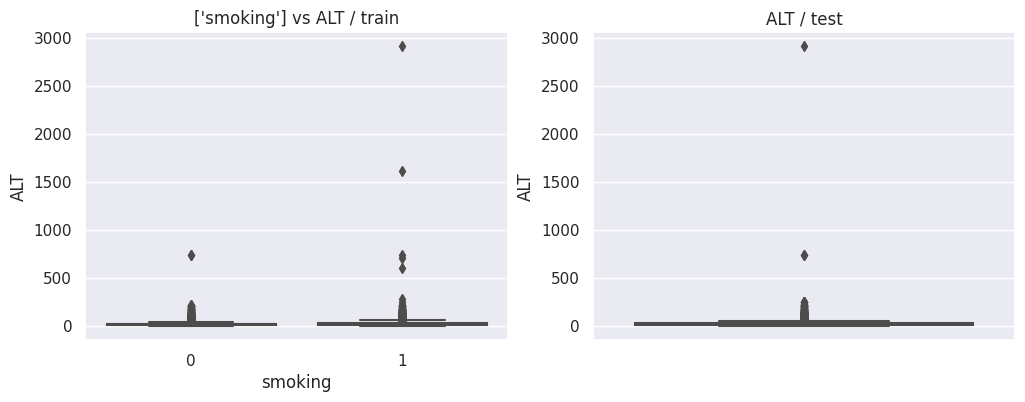

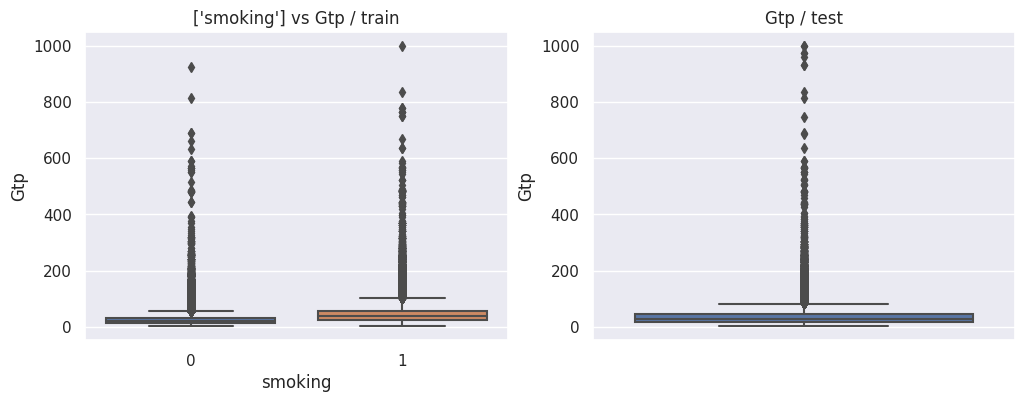

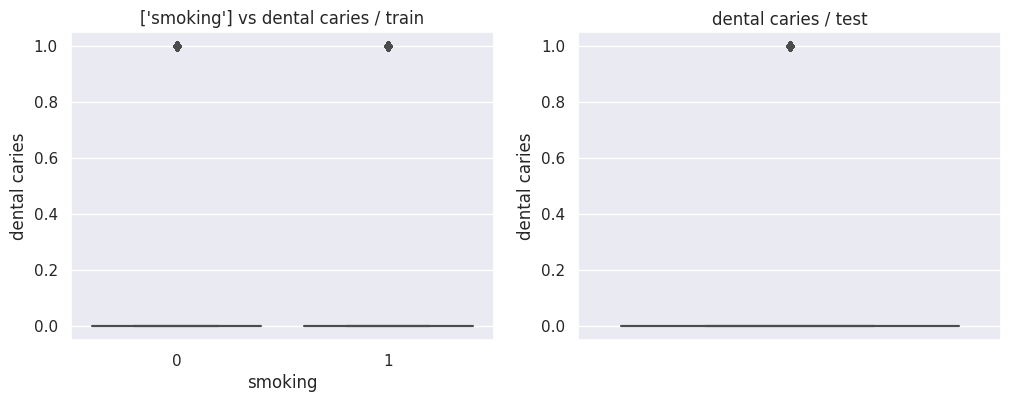

In [38]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

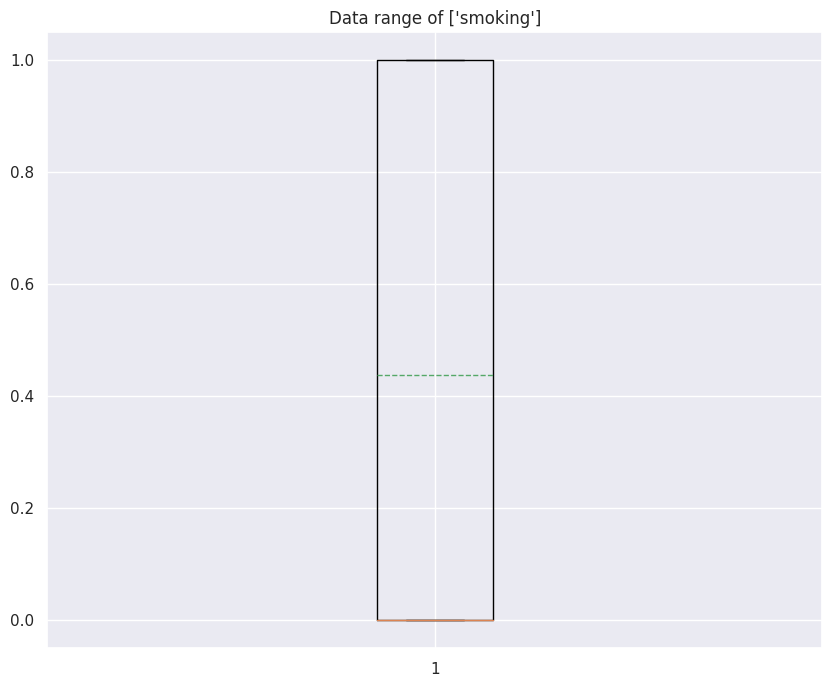

In [39]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

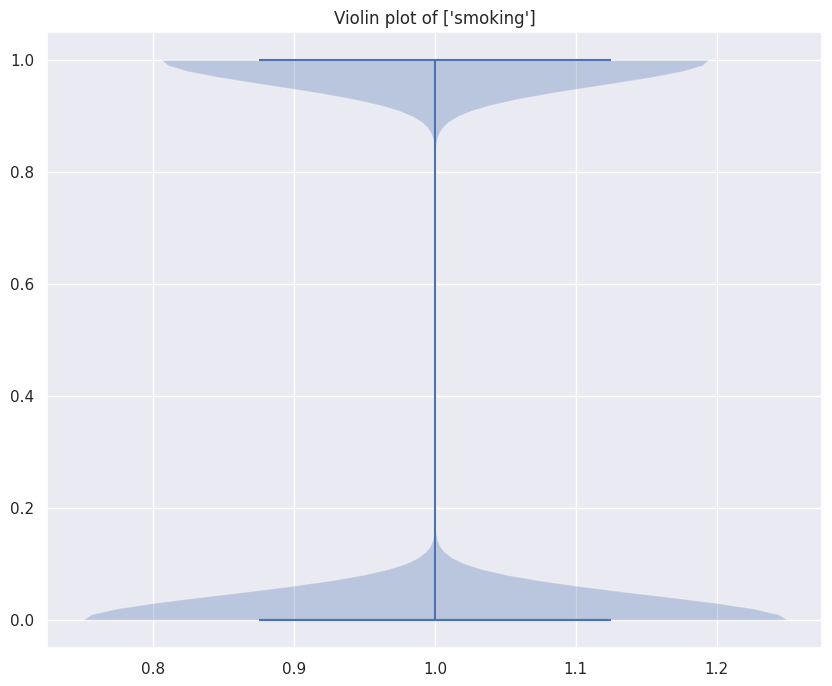

In [40]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

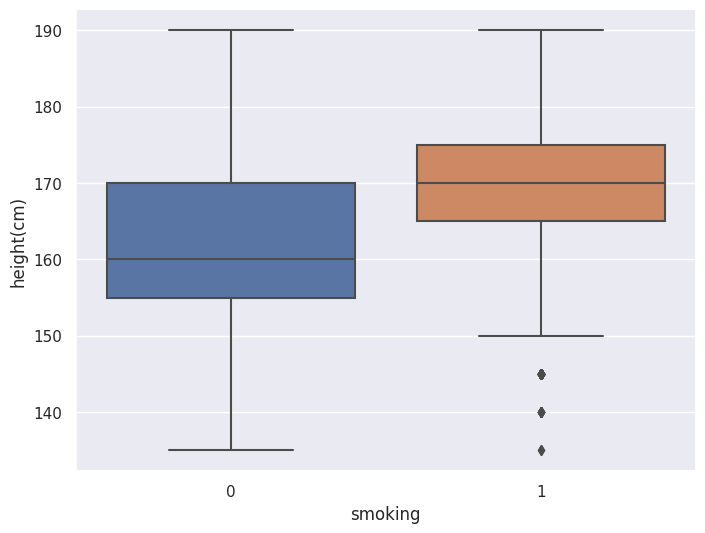

In [41]:
# 目的変数と'height(cm)'（最も特徴重要度の高い説明変数）との関係
train_height = 'height(cm)'
categorical_variate_corr = pd.concat([target, train[train_height]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=target, y=train_height, data=categorical_variate_corr)
fig.axis();

### 特徴量の重要度評価

CPU times: user 7.3 s, sys: 609 ms, total: 7.91 s
Wall time: 2.75 s


<Axes: >

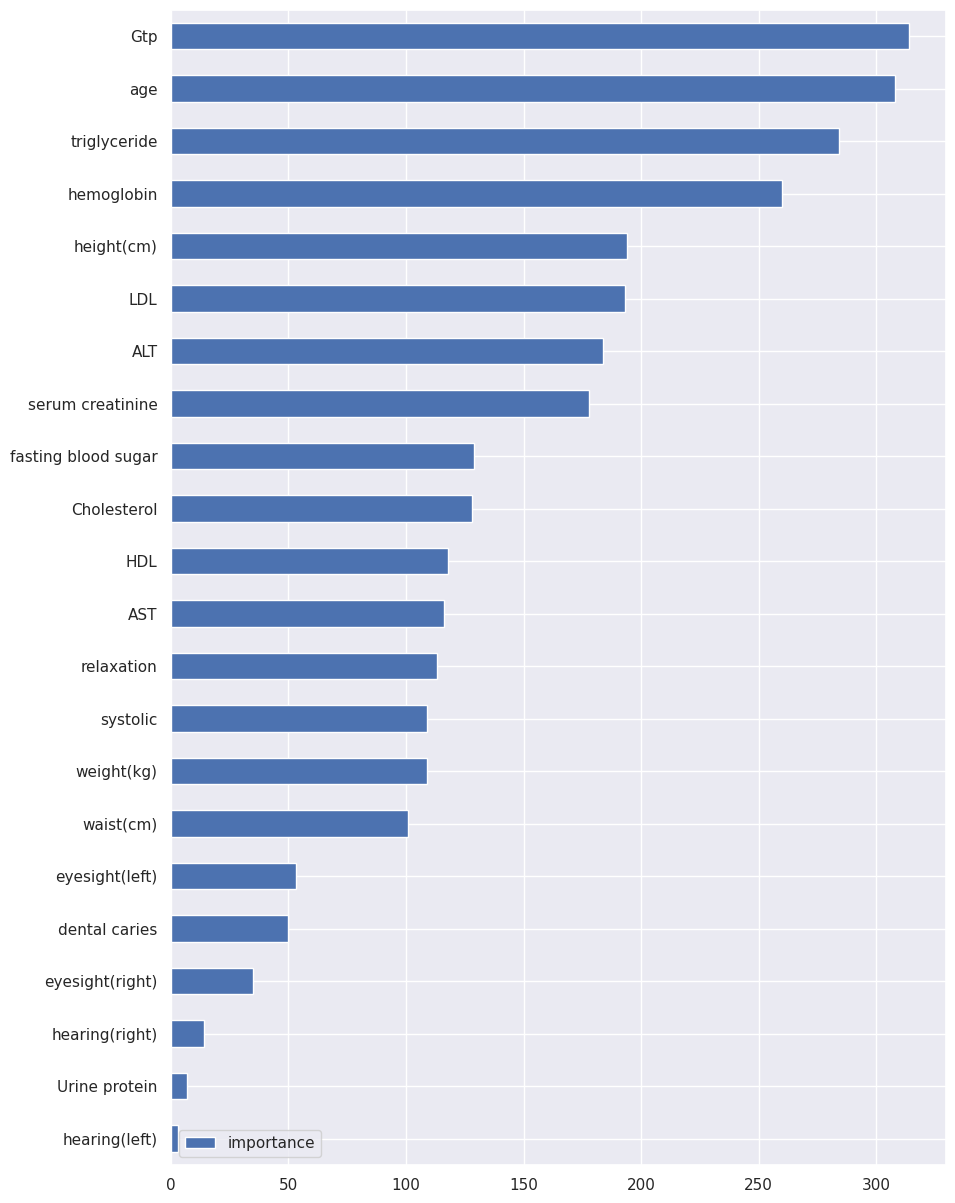

In [42]:
%%time

lgb = LGBMClassifier(
    random_state=42,
)

lgb.fit(X, y)
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [43]:
feature_importance

importance
hearing(left)                 3
Urine protein                 7
hearing(right)               14
eyesight(right)              35
dental caries                50
eyesight(left)               53
waist(cm)                   101
weight(kg)                  109
systolic                    109
relaxation                  113
AST                         116
HDL                         118
Cholesterol                 128
fasting blood sugar         129
serum creatinine            178
ALT                         184
LDL                         193
height(cm)                  194
hemoglobin                  260
triglyceride                284
age                         308
Gtp                         314

* 'Gtp'が重要度が特に高い
* 'hearing(right, left)'が低い

### 相関（ヒートマップ）

<Axes: >

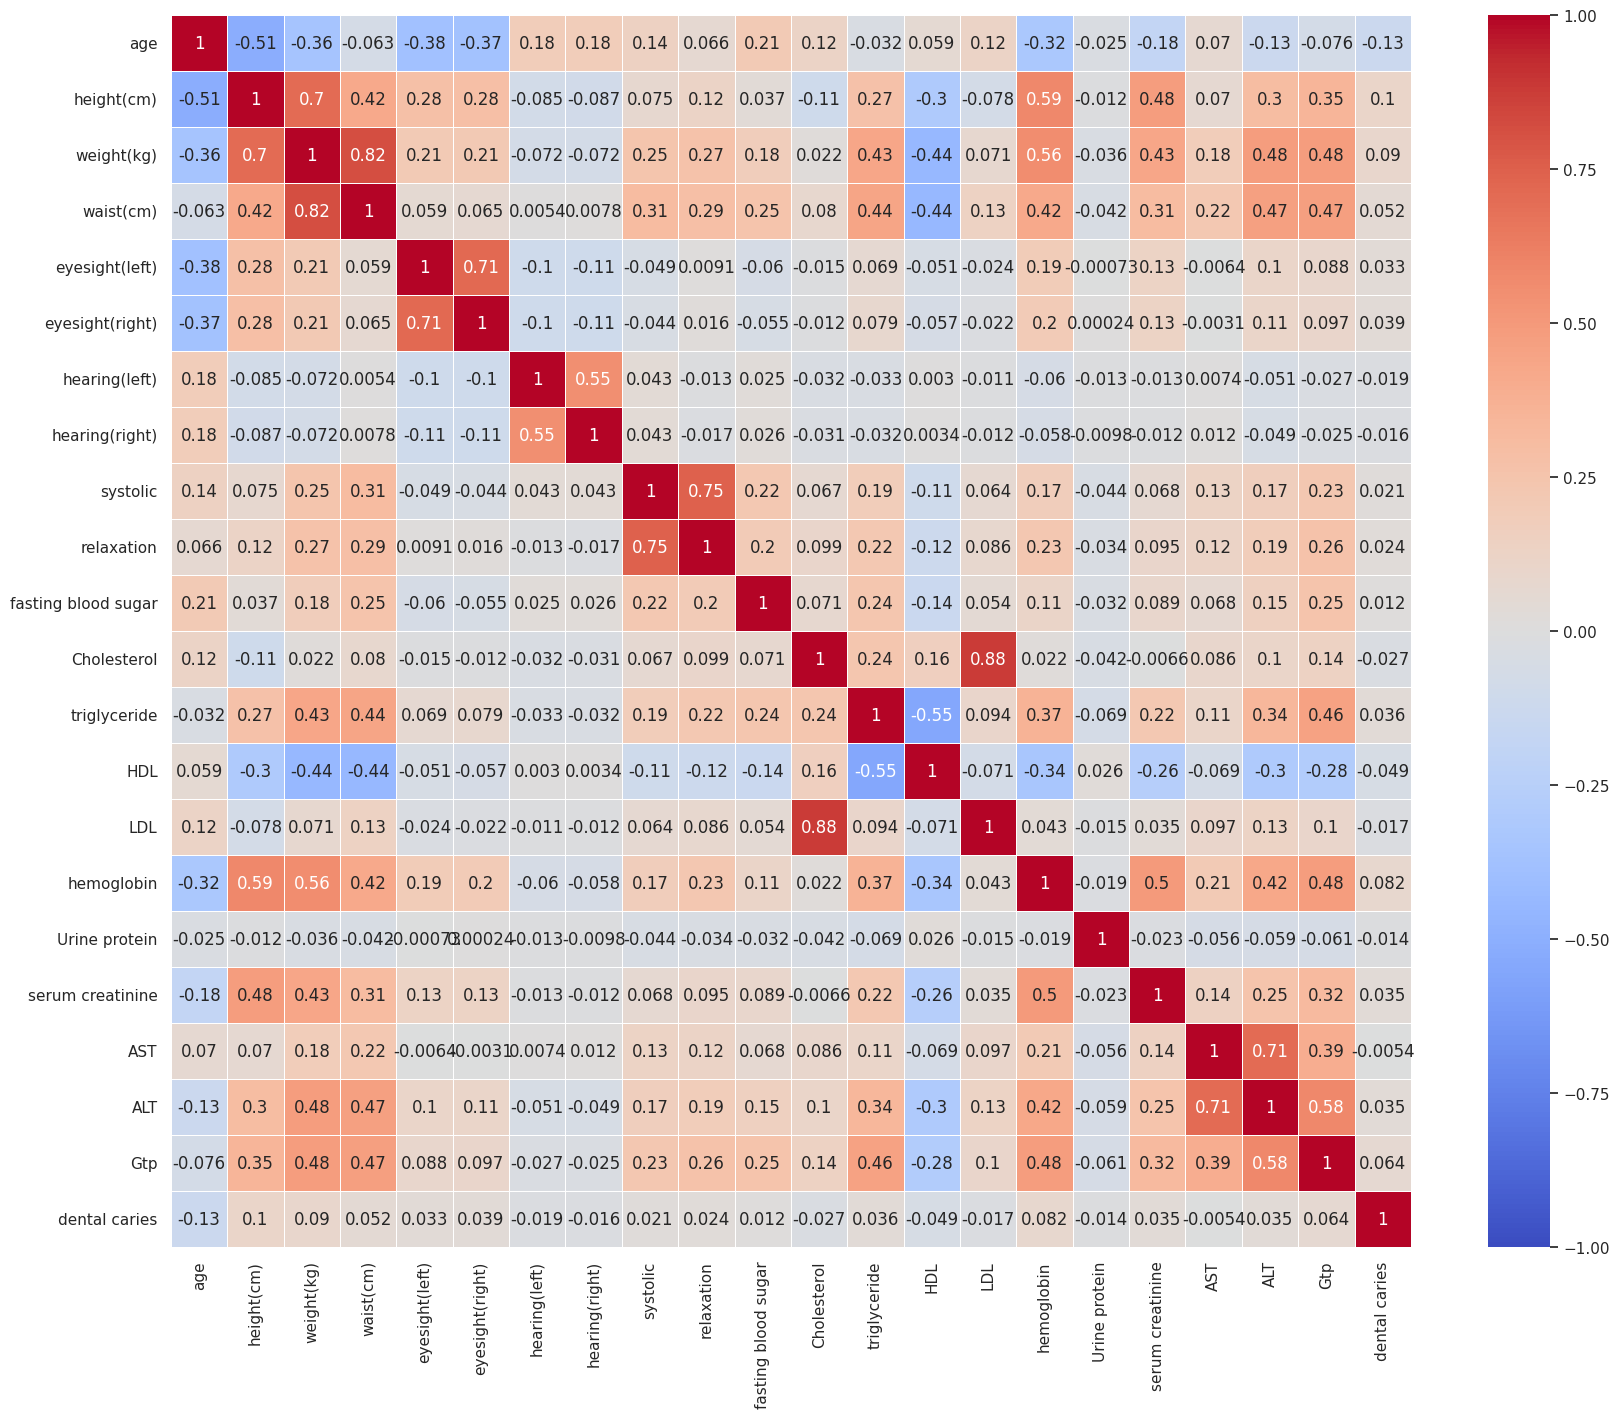

In [44]:
corr = train[numerical_features].corr(method='spearman')
plt.figure()
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

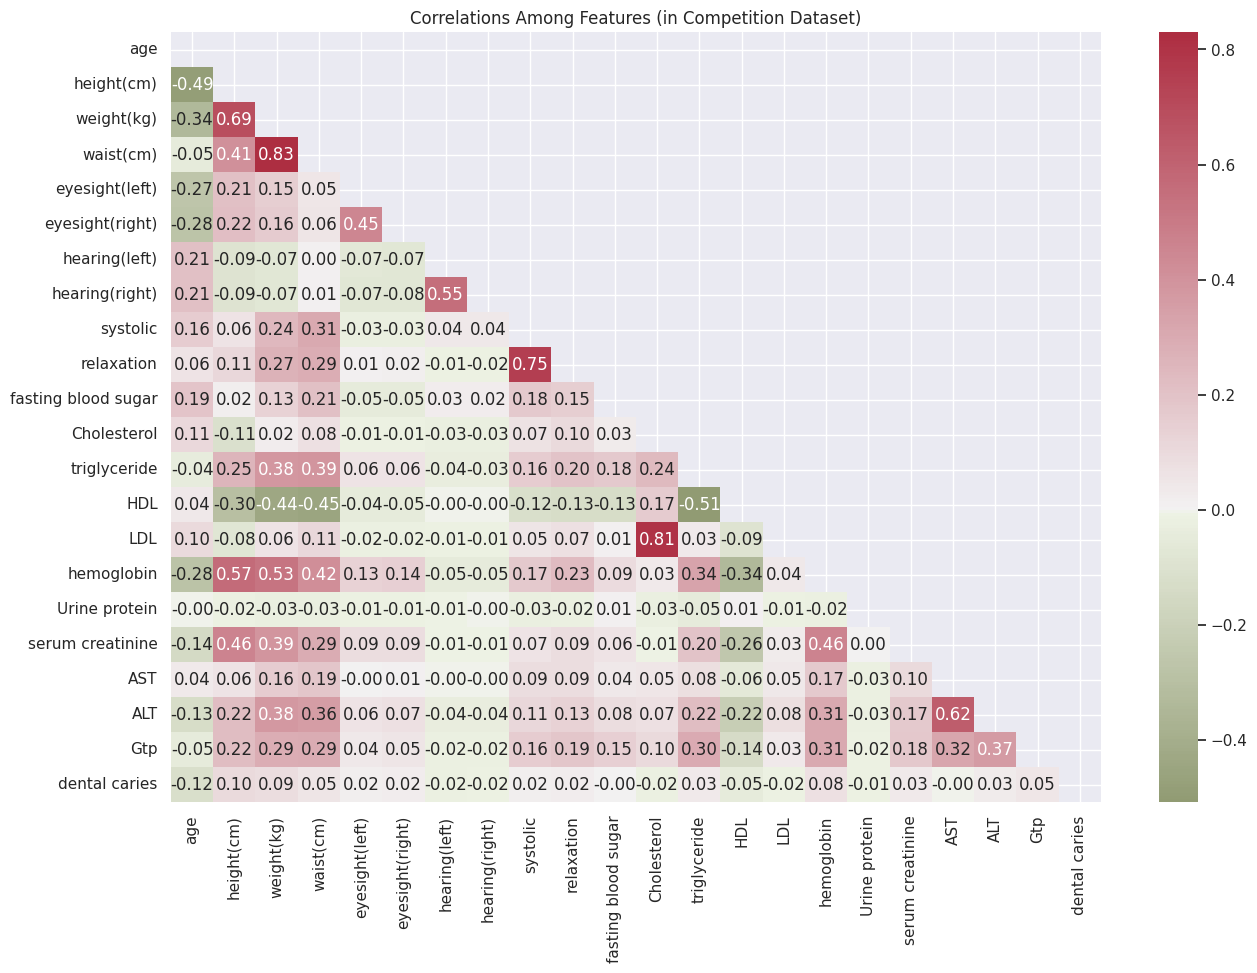

In [45]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

* 'waist(cm)'と'weight(kg)'の間には強い負の相関がある（83%の相関）
* 'LDL' と 'Cholesterol'は81％の相関
* 'relaxation' は 'systolic'との間で強い相関がある（75%の相関）
* 'HDL' が 'triglyceride' との間で最も高い負相関を持つ

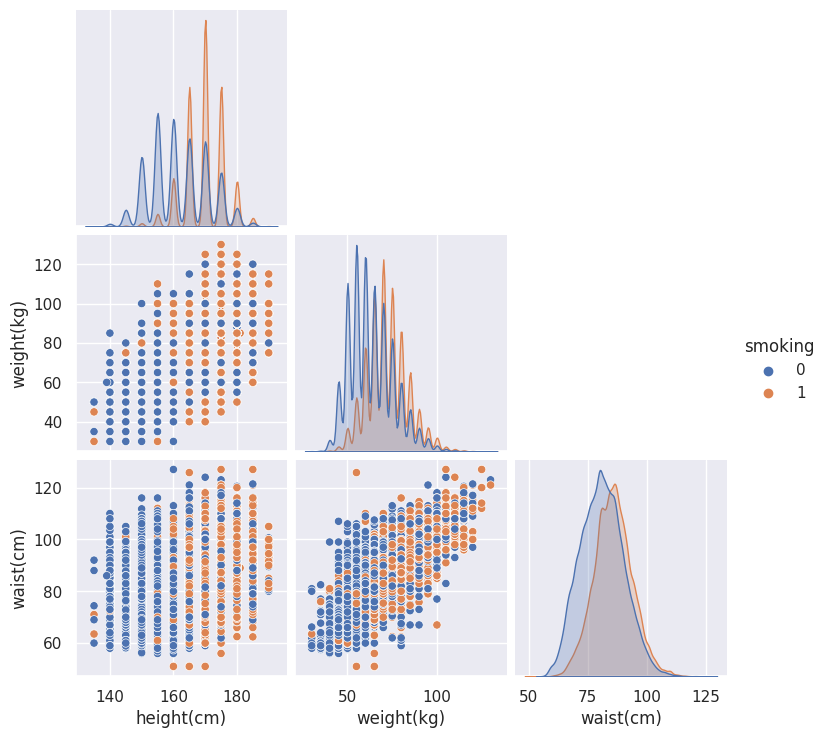

In [46]:
# 'height(cm)', 'weight(kg)', 'waist(cm)'とsmoking(目的変数)との相関関係を調べる
sns.pairplot(data=train[['height(cm)', 'weight(kg)', 'waist(cm)', 'smoking']], hue='smoking', corner=True);

- 身長が高い人（体重も重い傾向があります）は喫煙する傾向がある
- 体重（kg）とウエスト（cm）の関係はほぼ直線的

In [47]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()['smoking'] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

smoking                1.00000
hemoglobin             0.45068
height(cm)             0.44711
weight(kg)             0.35175
triglyceride           0.33198
Gtp                    0.30556
serum creatinine       0.27298
waist(cm)              0.26271
ALT                    0.16302
eyesight(right)        0.10978
relaxation             0.10950
dental caries          0.10664
eyesight(left)         0.10042
fasting blood sugar    0.09653
AST                    0.05939
systolic               0.05864
Urine protein         -0.02855
hearing(right)        -0.03686
hearing(left)         -0.03822
Cholesterol           -0.05190
LDL                   -0.07229
age                   -0.20603
HDL                   -0.27119
Name: smoking, dtype: float64

### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

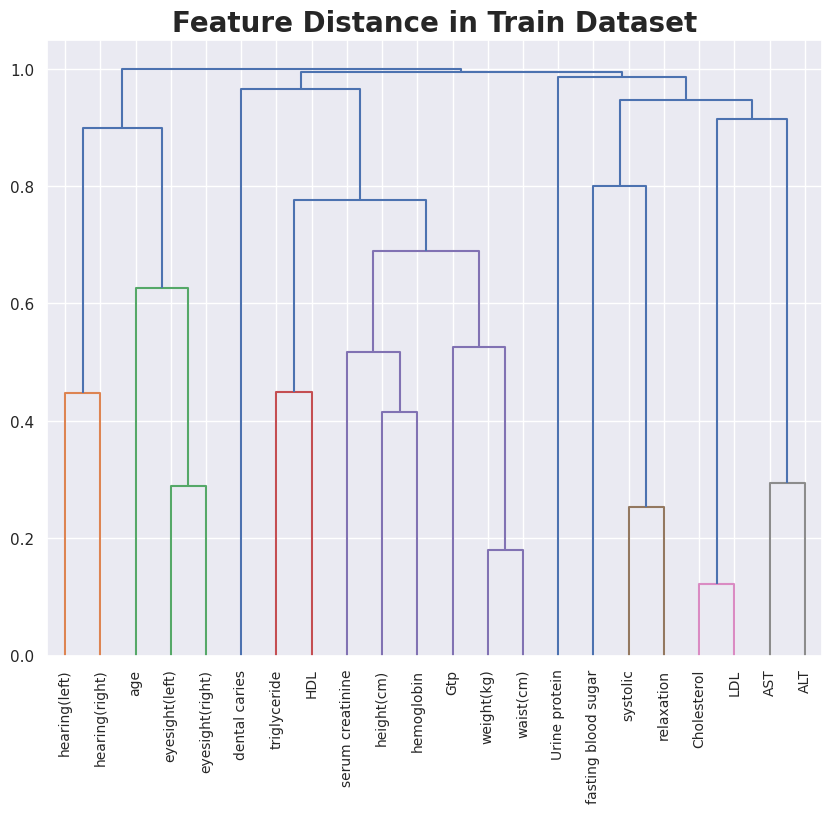

In [48]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train[numerical_features], 'Train')

#### 散布図

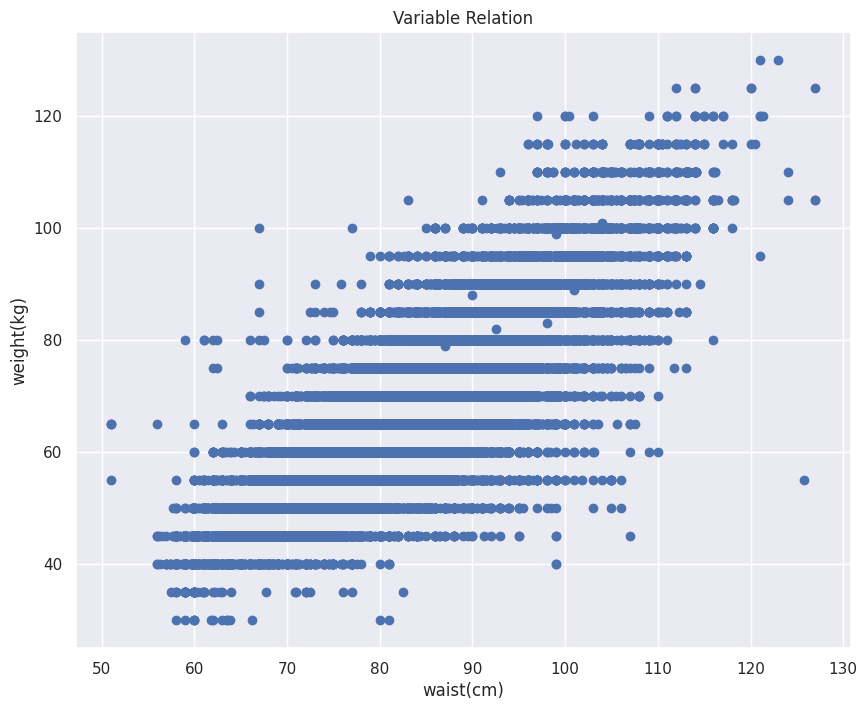

In [49]:
# ヒートマップの結果から、散布図で変数の関係性を調べる
train_waist = train['waist(cm)']
train_weight = train['weight(kg)']

plt.figure(figsize=(10, 8))

plt.scatter(train_waist, train_weight)
plt.title('Variable Relation')
plt.xlabel('waist(cm)')
plt.ylabel('weight(kg)')
plt.grid(True)

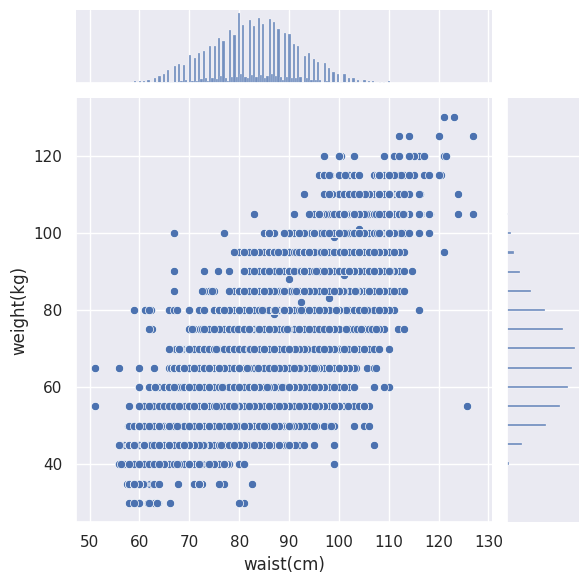

In [50]:
# 二変量グラフと単変量グラフを作成する
sns.jointplot(x=train_waist, y=train_weight, data=train)

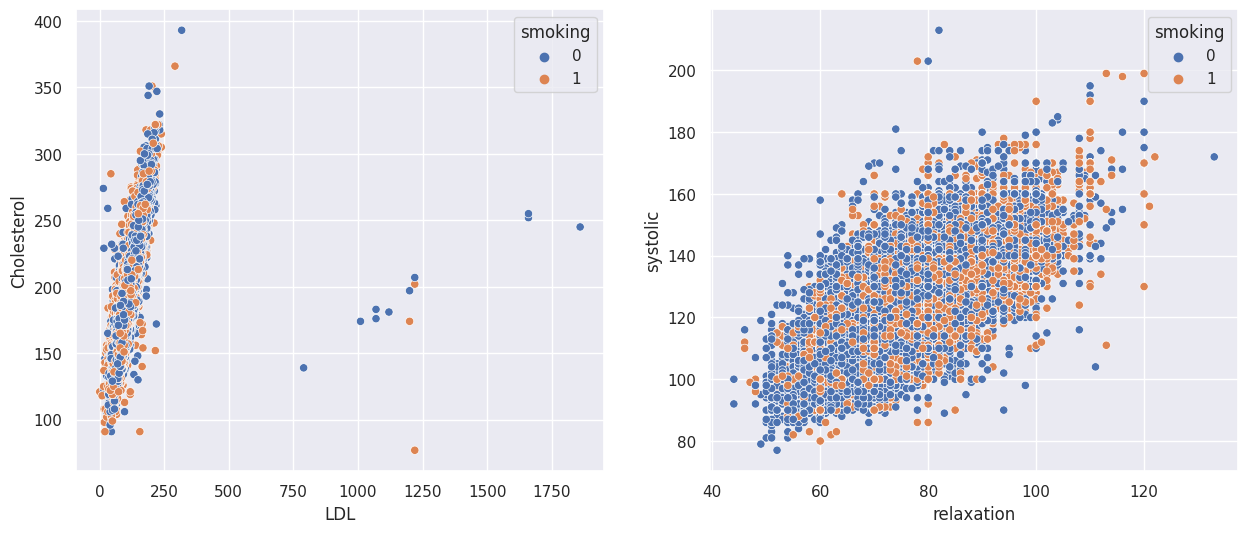

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax=axes[0], data=train, x='LDL', y='Cholesterol', hue='smoking')
sns.scatterplot(ax=axes[1], data=train, x='relaxation', y='systolic', hue='smoking');

## EDAの可視化するためのライブラリ

In [52]:
report = sv.compare([train, "Train"], [test, "Test"], target_feat='smoking')
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 実行時間を調べるために使う

In [53]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'5m31s'